# Youtube Channel Recommendation for Influencer Marketing


YouTube nowadays is the largest video hosting website, and it has profound influences on the U.S. This project can help marketing team to select youtube channel and influencer for marketing their business. *This project will provide business recommendations for them, including which channels have more business value and what people are concerning about now.*


**1. I will find the category that have relatively higher business potential.**   
I will estimate the value of category from these metrics:     
1) `the number of videos in each category`  
2) `average view count`  
3) `variance of view count`  
4) `average time interval(trending_date-publishedAt)`  

**2. I will find out hottest channels from the** `appearance frequency`, `like to dislike Ratio`, `growth rate`, `sentiment polarity`. **In addition, I will help marketing team choose these channels/YouTubers to see if these channels/YouTubers match the characteristics of their products and find potential customers.**


## Data Description

In order to get the data from youtube, I used a script, which is reference from GitHub: https://github.com/DataSnaek/Trending-YouTube-Scraper, to collect data. This youtube scraper can scrape the most trending video from different countries, however, I will mainly focus on the US trending videos based on the data we collected through *March and April 2019.*


`Video_id`: the unique identity of a video     
`Trending_date`: the date that video is ranked     
`Title`: the title of video of the video     
`Channel_title`: the title of the channel which the video belongs to     
`Category_id`: the category of video, which can be looked up using the included JSON files     
`Publish_time`: the time video was published     
`Tags`: the tags a video contains     
`Views`: the number of views each video have     
`Likes`: the number of like each video have     
`Dislikes`: the number of dislikes each video have     
`Comment_count`: the number of comment each video have     
`Thumbnail_link`: the link connected to the cover page     
`Comments_disabled`: if people can leave comments or not     
`Ratings_disabled`: if people can rate the video or not     
`Description`: description of the video     


## Data Cleaning

In [32]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

import glob
from wordcloud import WordCloud, STOPWORDS
import nltk
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
from math import pi


In [2]:
data = pd.read_csv("data/Data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10021 entries, 0 to 10020
Data columns (total 16 columns):
video_id             10021 non-null object
title                10000 non-null object
publishedAt          10000 non-null object
channelId            10000 non-null object
channelTitle         10000 non-null object
categoryId           10000 non-null float64
trending_date        10000 non-null object
tags                 10000 non-null object
view_count           10000 non-null float64
likes                10000 non-null float64
dislikes             10000 non-null float64
comment_count        10000 non-null float64
thumbnail_link       10000 non-null object
comments_disabled    10000 non-null object
ratings_disabled     10000 non-null object
description          9965 non-null object
dtypes: float64(5), object(11)
memory usage: 1.2+ MB


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,adzYW5DZoWs,Star Wars: The Rise of Skywalker – Teaser,2019-04-12T17:08:15.000Z,UCZGYJFUizSax-yElQaFDp5Q,Star Wars,24.0,19.14.04,Star Wars|Lucasfilm|Star Wars: Episode IX|JJ A...,17494243.0,429969.0,51877.0,71884.0,https://i.ytimg.com/vi/adzYW5DZoWs/default.jpg,False,False,Every generation has a legend. Watch the brand...
1,0GLbwkfhYZk,Star Wars Jedi: Fallen Order — Official Reveal...,2019-04-13T18:41:22.000Z,UCOsVSkmXD1tc6uiJ2hc0wYQ,EA Star Wars,20.0,19.14.04,Star Wars Jedi Fallen Order|Star Wars|Star War...,2125167.0,101509.0,3809.0,15366.0,https://i.ytimg.com/vi/0GLbwkfhYZk/default.jpg,False,False,Cal Kestis—one of the last surviving members o...
2,QuderoyWqII,Magic Star ⭐ Concealer & Setting Powder Reveal...,2019-04-12T19:00:59.000Z,UCkvK_5omS-42Ovgah8KRKtg,jeffreestar,26.0,19.14.04,jeffree star|jeffree star concealer|magic star...,5373596.0,289698.0,8386.0,36440.0,https://i.ytimg.com/vi/QuderoyWqII/default.jpg,False,False,The Magic Star™ Concealer & Setting Powder lau...
3,XsX3ATc3FbA,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,2019-04-12T09:00:02.000Z,UC3IZKseVpdzPSBaWxBxundA,ibighit,10.0,19.14.04,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄|작은 것들을 위한 시|Bo...,108445779.0,7597407.0,280945.0,2605772.0,https://i.ytimg.com/vi/XsX3ATc3FbA/default.jpg,False,False,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...
4,-9txATEWXTQ,THE TRUTH... My Crush Does My Makeup,2019-04-12T19:10:06.000Z,UCucot-Zp428OwkyRm2I7v2Q,James Charles,24.0,19.14.04,james|james charles|makeup artist|mua|covergir...,5721920.0,361039.0,9842.0,32205.0,https://i.ytimg.com/vi/-9txATEWXTQ/default.jpg,False,False,"HI SISTERS! In today's video, I wanted to fina..."


In [3]:
# Check null values
data.isnull().sum()

video_id              0
title                21
publishedAt          21
channelId            21
channelTitle         21
categoryId           21
trending_date        21
tags                 21
view_count           21
likes                21
dislikes             21
comment_count        21
thumbnail_link       21
comments_disabled    21
ratings_disabled     21
description          56
dtype: int64

In [4]:
# Drop null values
data = data[pd.notnull(data['title'])]

# Pair the category id with category title
categories = {}
with open('data/US_category_id.json', 'r') as f:
    category = json.load(f)
    for i in category['items']:
        categories[int(i['id'])] = i['snippet']['title']
data['category'] = [categories[i] for i in data['categoryId']]


In [5]:
# Reformat datetime
data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%d')
data['trending_date'] = pd.to_datetime(data['trending_date'], format='%y.%d.%m')

# Drop columns we do not use
data.drop(['thumbnail_link', 'categoryId','channelId','video_id'], axis=1, inplace=True)

missing=data.loc[(data['view_count'] ==0) | (data['likes'] ==0)|(data['dislikes'] ==0)|(data['comment_count'] ==0)]
data.head()

,title,publishedAt,channelTitle,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category
0,Star Wars: The Rise of Skywalker – Teaser,2019-04-12 17:08:15+00:00,Star Wars,2019-04-14,Star Wars|Lucasfilm|Star Wars: Episode IX|JJ A...,17494243.0,429969.0,51877.0,71884.0,False,False,Every generation has a legend. Watch the brand...,Entertainment
1,Star Wars Jedi: Fallen Order — Official Reveal...,2019-04-13 18:41:22+00:00,EA Star Wars,2019-04-14,Star Wars Jedi Fallen Order|Star Wars|Star War...,2125167.0,101509.0,3809.0,15366.0,False,False,Cal Kestis—one of the last surviving members o...,Gaming
2,Magic Star ⭐ Concealer & Setting Powder Reveal...,2019-04-12 19:00:59+00:00,jeffreestar,2019-04-14,jeffree star|jeffree star concealer|magic star...,5373596.0,289698.0,8386.0,36440.0,False,False,The Magic Star™ Concealer & Setting Powder lau...,Howto & Style
3,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,2019-04-12 09:00:02+00:00,ibighit,2019-04-14,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄|작은 것들을 위한 시|Bo...,108445779.0,7597407.0,280945.0,2605772.0,False,False,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,Music
4,THE TRUTH... My Crush Does My Makeup,2019-04-12 19:10:06+00:00,James Charles,2019-04-14,james|james charles|makeup artist|mua|covergir...,5721920.0,361039.0,9842.0,32205.0,False,False,"HI SISTERS! In today's video, I wanted to fina...",Entertainment


#### Correlation between `view_count`, `ikes` ,`dislikes` , and `comment_count`

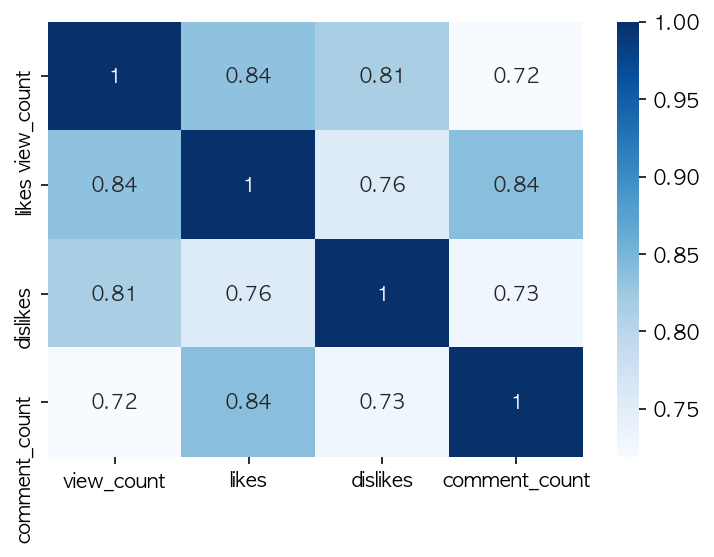

In [6]:
correlation = data[['view_count', 'likes', 'dislikes', 'comment_count']].corr()
sns.heatmap(correlation, cmap='Blues', annot=True)

We can check that view_count, ikes ,dislikes , and comment_count have strong correlations.

## Data Analysis Task 1: Category Selection

For our analysis, we aimed to find out the top valuable categories and select one of them to do further study. So, we decided to look at following four attributes by category to assess categories and developed a matrix:

- `Number of trending videos`
- `Average view count`
- `Variance of view count`
- `Average time interval(trending_date-publishedAt)`


### Number of Trending Videos

Text(0, 0.5, 'Count')

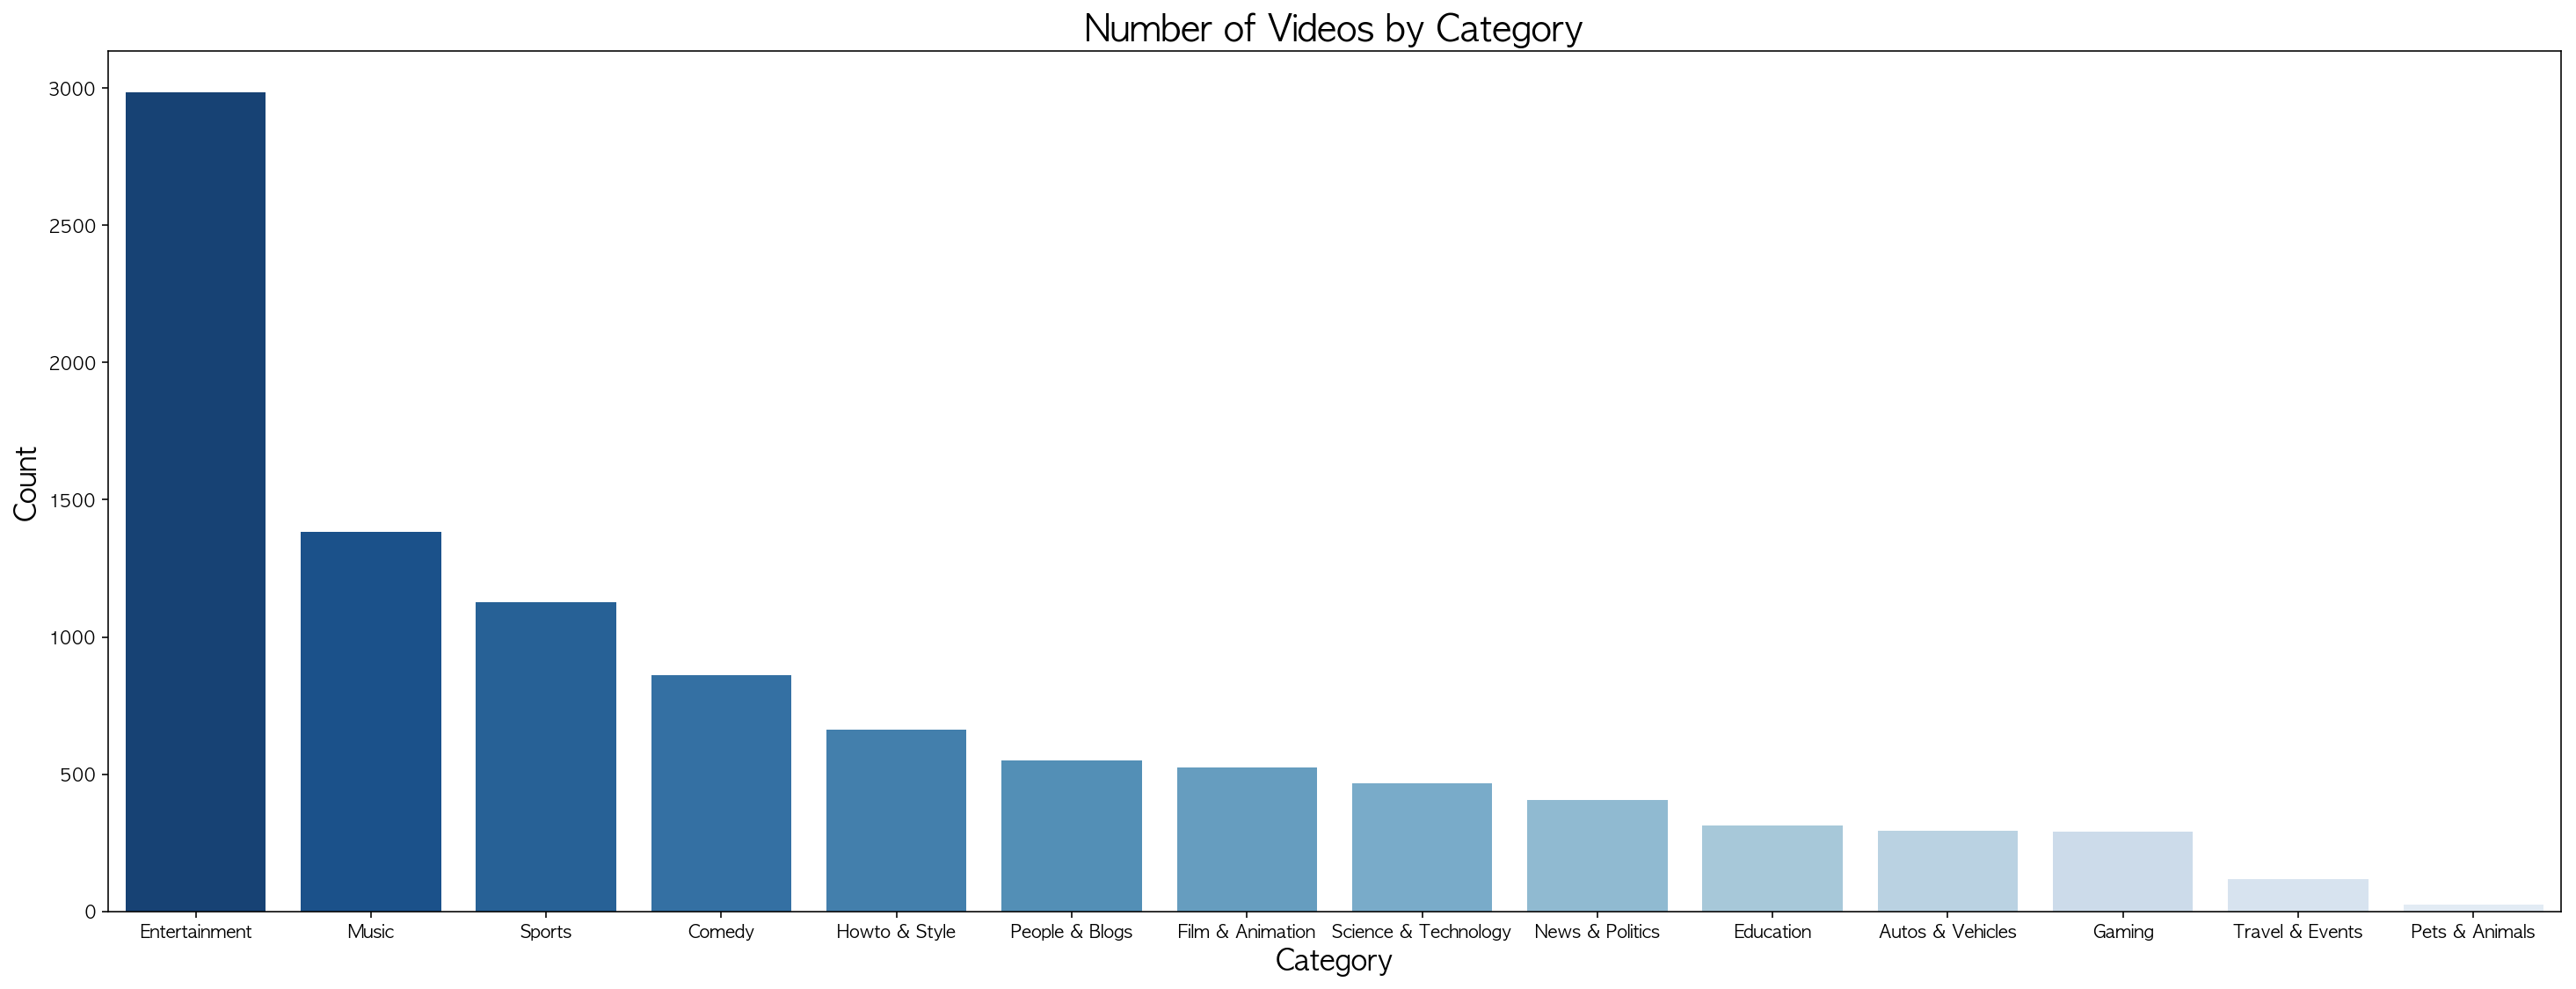

In [7]:
# Plot the number of video by category
plt.figure(figsize = (25,9))
sns.countplot(data['category'],
              order=data['category'].value_counts().index,
              palette=sns.color_palette("Blues_r", 15))

plt.title('Number of Videos by Category', fontsize=20)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Count', fontsize=16)



This plot shows that Entertainment category has the highest amount of trending videos. The amount of entertainment videos is close to 3000.
This indicates that entertainment is the most trending category that people are focusing on, but it may be the result of large scale of entertainment videos on YouTube website, so we would like to see average view count of different categories.

### Average View Count

This indicator is calculated by deviding the total view count by the number of videos of each category. It describes the average level of views for different categories.

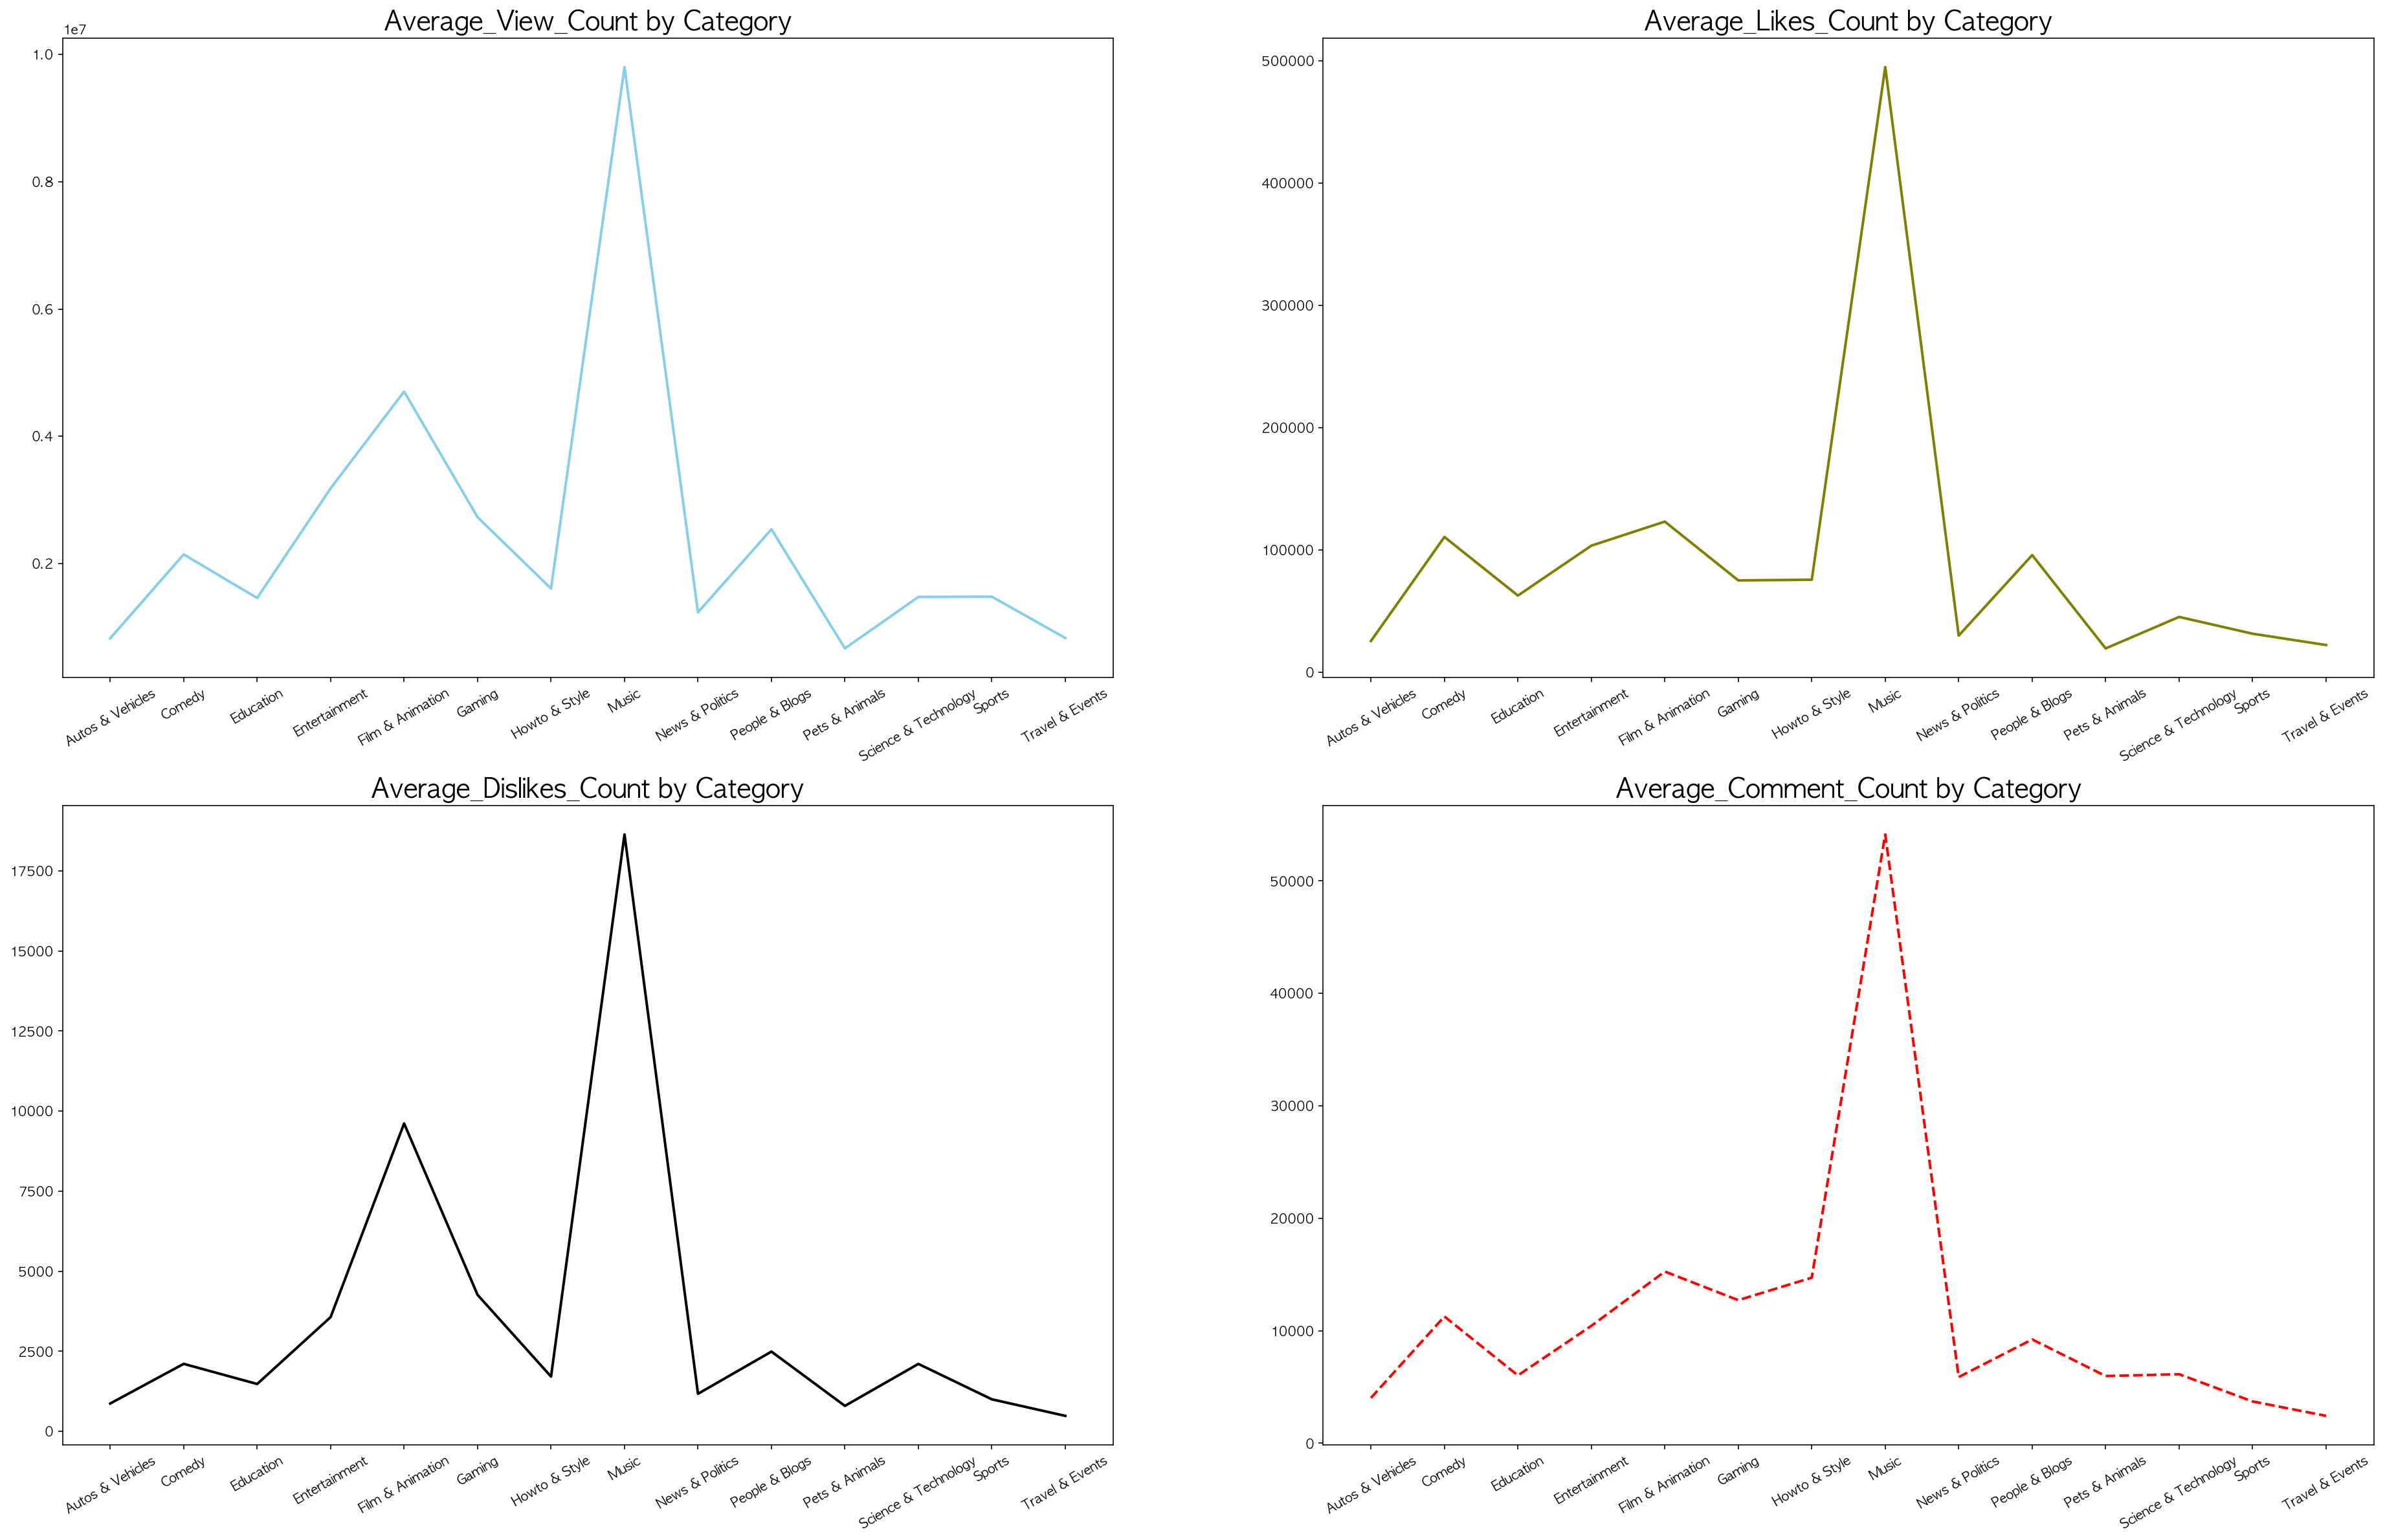

In [8]:
# The average of four numeric attributes 
general_view= pd.DataFrame(data[['view_count', 'likes', 'dislikes', 'comment_count']]\
                            .groupby(data['category']).mean())

plt.figure(figsize=(32,20))
plt.subplot(2,2,1)
plt.plot( general_view.index,'view_count' , data=general_view, color='skyblue', linewidth=2)
plt.title('Average_View_Count by Category',fontsize=20)
plt.xticks(rotation=30)
plt.subplot(2,2,2)
plt.plot( general_view.index, 'likes', data=general_view, color='olive', linewidth=2)
plt.title('Average_Likes_Count by Category',fontsize=20)
plt.xticks(rotation=30)
plt.subplot(2,2,3)
plt.plot( general_view.index, 'dislikes', data=general_view, color='black', linewidth=2)
plt.title('Average_Dislikes_Count by Category',fontsize=20)
plt.xticks(rotation=30)
plt.subplot(2,2,4)
plt.plot( general_view.index, 'comment_count', data=general_view, color='red', linewidth=2, linestyle='dashed')
plt.title('Average_Comment_Count by Category',fontsize=20)
plt.xticks(rotation=30);

With music always be the top category, the Film shows a quit difference trends in these plots that it significantly high in the 'Dislikes'. When we look back to see the distribution we find film has very high variance. The reason behind this may because during these two month, some film or television works cause very high negative emotions of the audience.

### Variance of View Count

The variance of view count uses the standard deviation of view counts of different categories. It describes how fluctuant the level of views is for different categories.

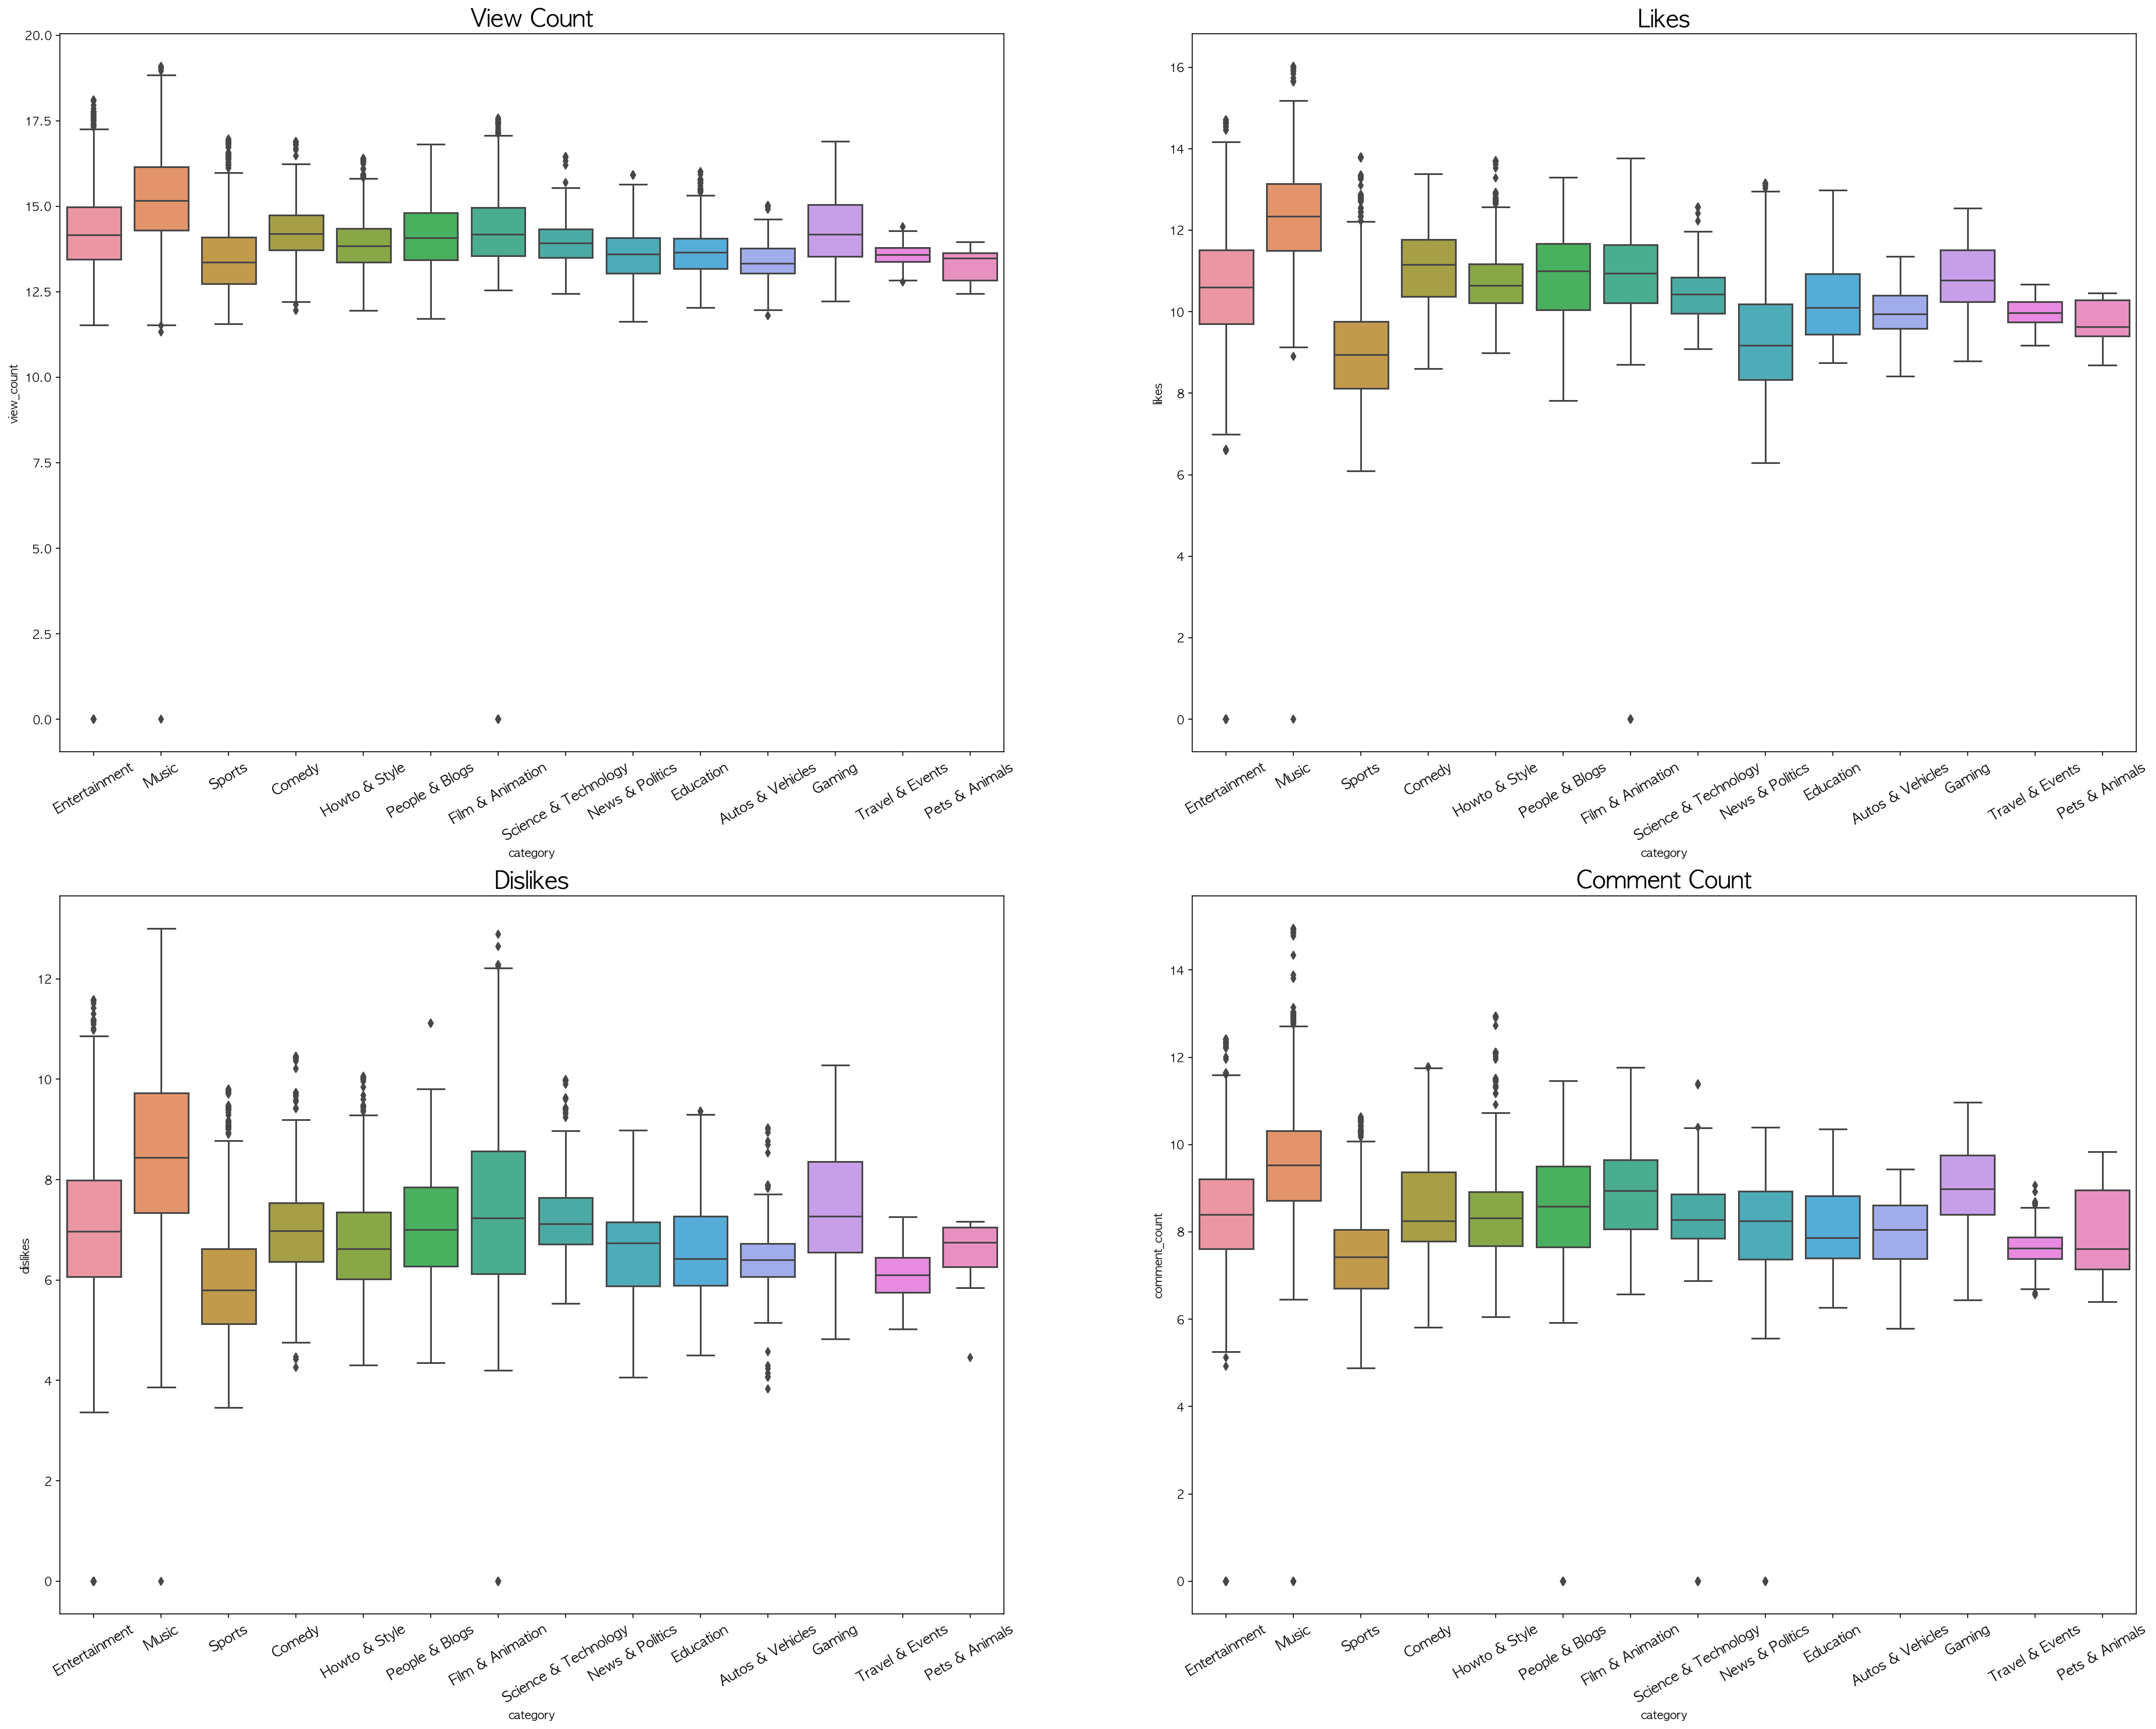

In [9]:
# Plot the distribution of 'view_count','likes','dislikes','comment_count'

view_count=np.log(data['view_count']+1 )
likes=np.log(data['likes']+1)
dislikes=np.log(data['dislikes']+1)
comment=np.log(data['comment_count']+1)
data_count=pd.concat([view_count,likes,dislikes,comment], axis=1)
data_count.index=data['category']
data_count = data_count[data_count.notnull()]

plt.figure(figsize=(32,25))
# distribution of view counts of different categories
plt.subplot(2,2,1)
sns.boxplot(x=data_count.index, y='view_count',data=data_count, order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.title("View Count", fontsize=20)


# distribution of likes of different categories
plt.subplot(2,2,2)
sns.boxplot(data_count.index,'likes', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.title("Likes", fontsize=20)

# distribution of dislikes of different categories
plt.subplot(2,2,3)
sns.boxplot(data_count.index,'dislikes', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.title("Dislikes", fontsize=20)

# distribution of comment counts of different categories
plt.subplot(2,2,4)
sns.boxplot(data_count.index,'comment_count', data=data_count,order = data['category'].value_counts().index)
plt.xticks(rotation=30,fontsize=12)
plt.title("Comment Count", fontsize=20);





By looking at the distribution of each attribute, we developed some insights:
     
- `Music`, `Entertainments`, `Film&Animation` have obviously *high variance*. Oppositely, `travel`, `Pets & Animals`, `auto &vehicles` have *stable variance*. According to *financial theory*, the more fluctuant the factor is, the more value we can gain from investment. For example, **the music and film category have high variance, so they should also be considered to invest.**      
        
- Comparing to the count view by category, which Entertainment has the highest value, Music becomes the top category on all four attributes based on the distributions, so this show that `Entertainment` may *not* be the most popular category, only because it has the largest video base so it can have so many videos go up on trending, but **`music` gets the most attention from people.**        
        
- `Gaming` is very prominent in the 'comment count', so do `music`,while `Pet` also have the lowest view and number of video, but also a significant trend in 'comment count'. This may reflect that these categories have *higher interactive between the audiences*.


### Average Time Interval

`time interval` = `trending date` - `published date`   
*The average time interval* for each category describes on average how fast a video can show up on the trending borad. This is also a important criterion that marketing team care about, because the longer time interval is, the larger the time cost will be.

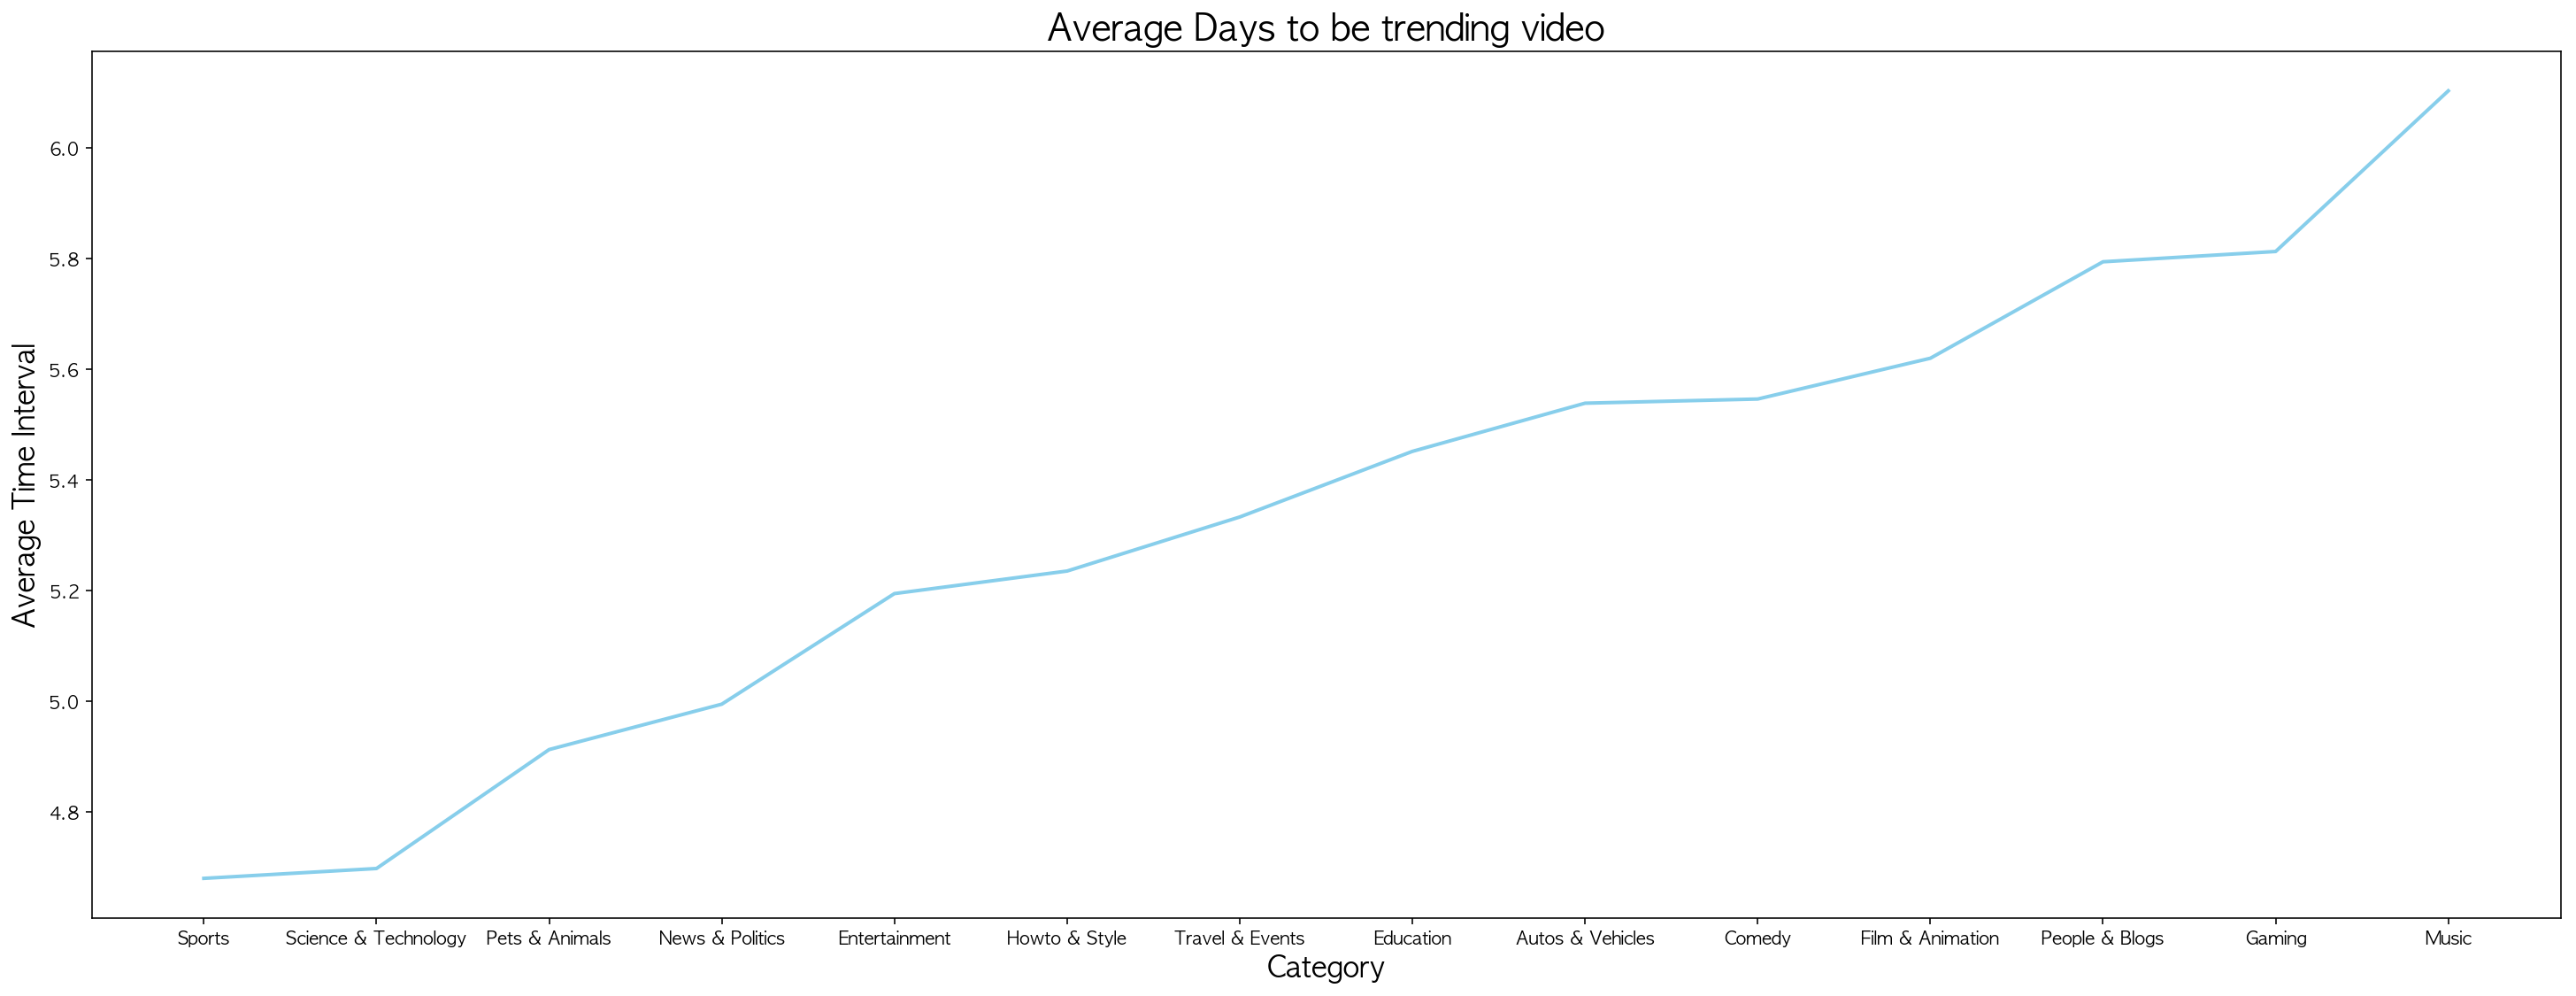

In [10]:
#the distribution of days that videos take to become popular
data['publish_date'] = data['publishedAt'].dt.date
data['publish_time'] = data['publishedAt'].dt.time
data['interval'] = (data['trending_date'].dt.date-data['publish_date']).astype('timedelta64[D]')


# Average time interval between published and trending
df_t = pd.DataFrame(data['interval'].groupby(data['category']).mean()).sort_values(by="interval")
plt.figure(figsize = (25,9))
plt.plot(df_t, color='skyblue', linewidth=2)
plt.title("Average Days to be trending video", fontsize=20)
plt.xlabel('Category',fontsize=16)
plt.ylabel('Average Time Interval',fontsize=16)
plt.show();






From this plot, we discovered that `Music` take more the longest time and the `science` takes the short time, nearly 4 days on average. This is because people watching `sport video` is more like to *capture latest information*, while `music video`'s attraction *decreases slower as time goes by*.

### Evaluation Matrix

In the evaluation matrix, including number of trending videos, average view count, variance of view count, and average time interval, I will use the reverse rank of each attribute as its score for categories, then summed up all the scores to get a final score of each category to select most valuable category to do further analysis.

In [11]:
# Create evaluation matrix by mean of time interval, number of videos, average view count, standard deviation of view count
Matrix1 = data.pivot_table(index="category", values=["view_count", "interval"], 
                 aggfunc={"interval": np.mean, "view_count":["count", np.std, np.mean]})
Matrix1.columns = ["interval_mean", "video_count", "view_mean", "view_std"]

# Generate socres for each character by descending the rank
for col in Matrix1.columns:
    Matrix1["{}_rank".format(col)] = Matrix1[col].rank(ascending=1)
Matrix1["interval_mean_rank"] = 15-Matrix1["interval_mean_rank"] # the shorter , the better

#Calculate total score
Matrix1["score"] = Matrix1.iloc[:,-4:].sum(axis=1)
Matrix1.sort_values(by="score", inplace=True, ascending=False)


In [12]:
# Matrix Ranking
Matrix1.drop(['interval_mean','video_count','view_mean','view_std'],axis=1)

,interval_mean_rank,video_count_rank,view_mean_rank,view_std_rank,score
category,,,,,
Entertainment,10.0,14.0,12.0,12.0,48.0
Music,1.0,13.0,14.0,14.0,42.0
Sports,14.0,12.0,7.0,9.0,42.0
Film & Animation,4.0,8.0,13.0,13.0,38.0
Howto & Style,9.0,10.0,8.0,7.0,34.0
Comedy,5.0,11.0,9.0,8.0,33.0
People & Blogs,3.0,9.0,10.0,10.0,32.0
Science & Technology,13.0,7.0,6.0,5.0,31.0
Gaming,2.0,3.0,11.0,11.0,27.0


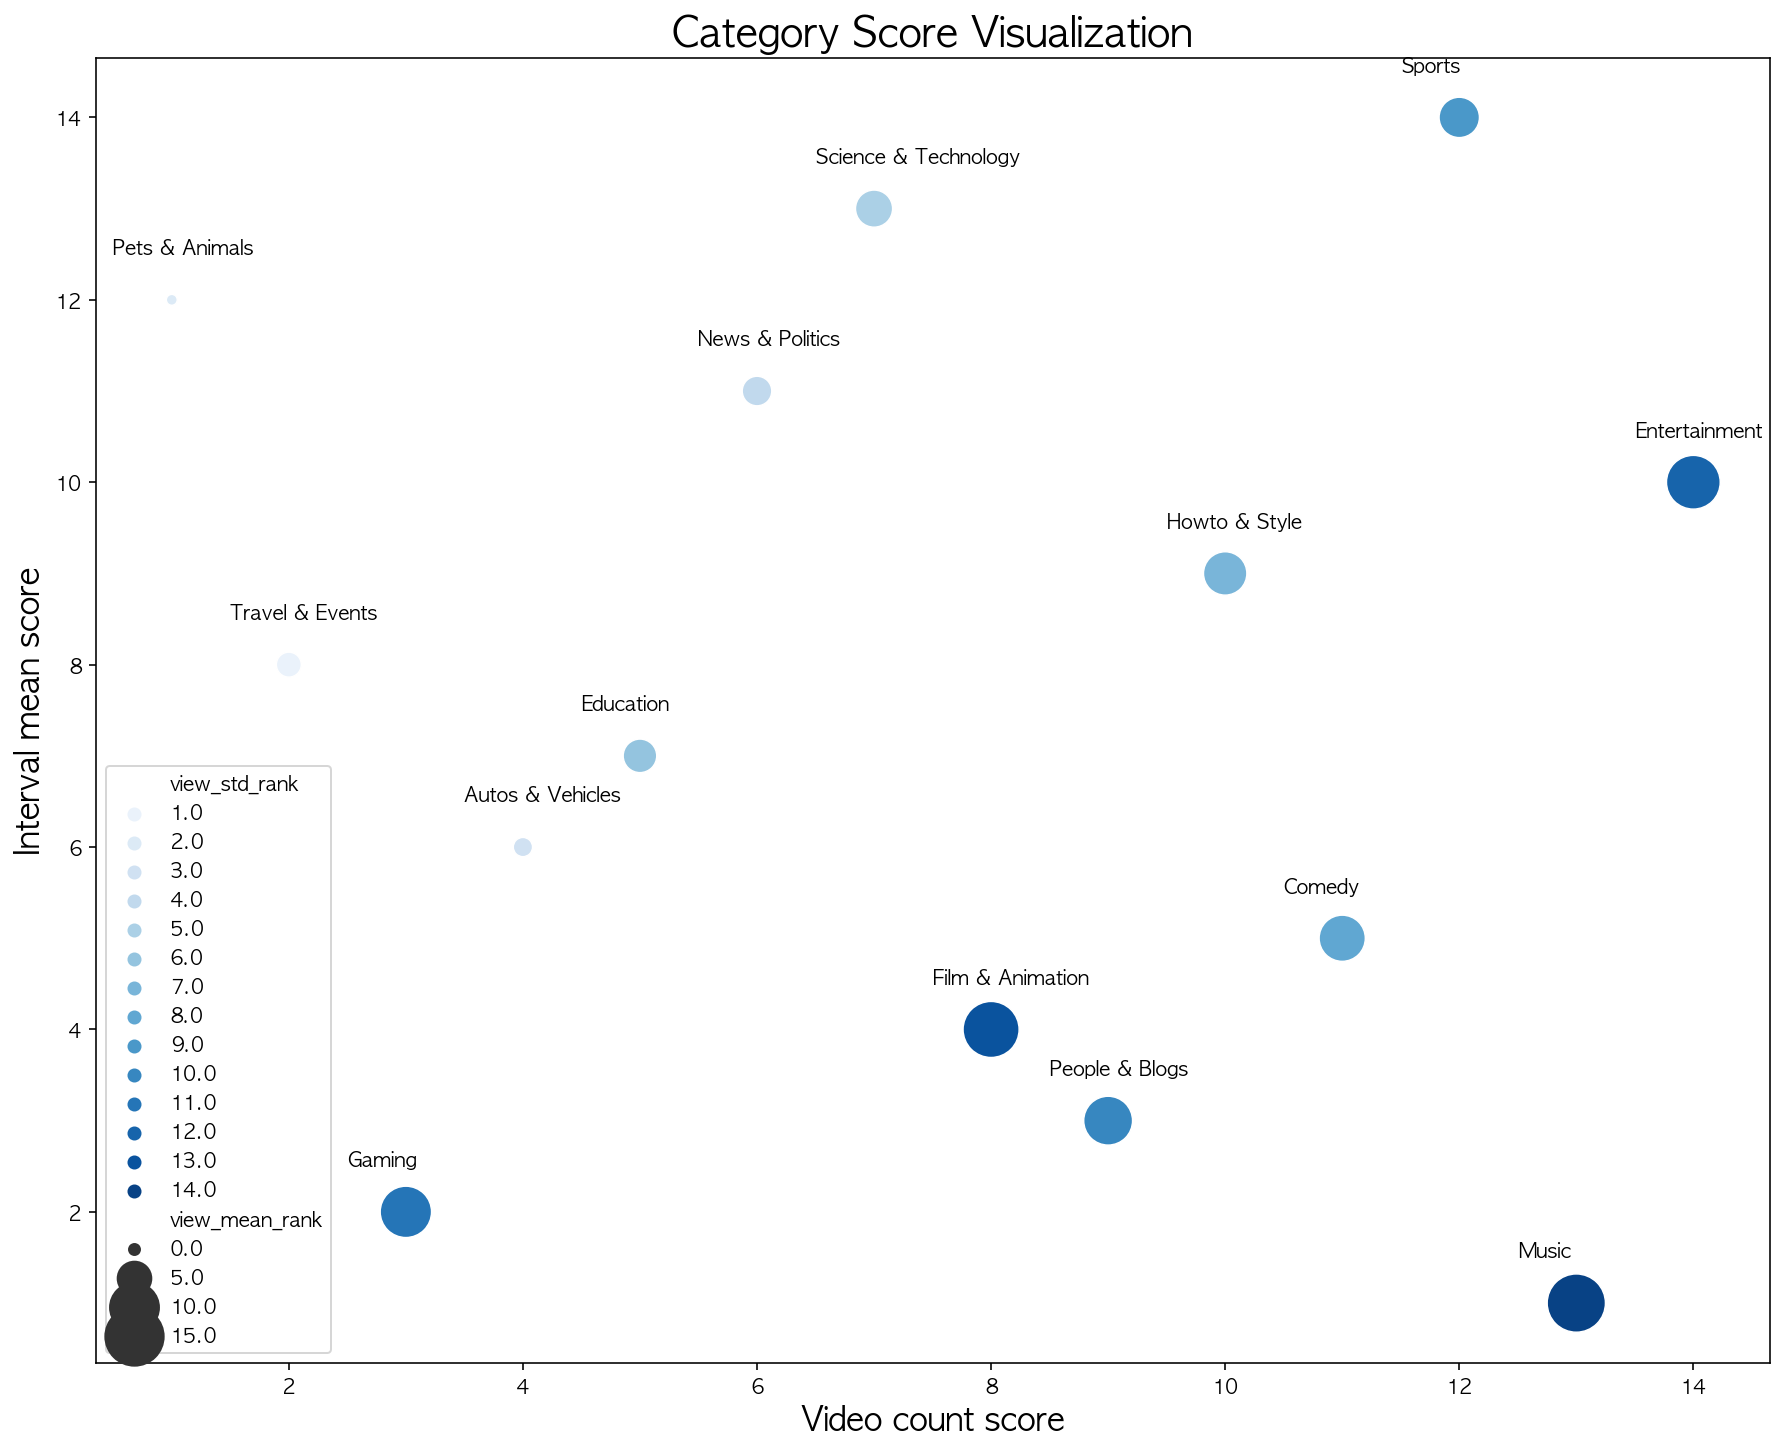

In [13]:
# Visualization of evaluation matrix
plt.figure(figsize = (15,12))

sns.scatterplot(data=Matrix1,
            x='video_count_rank',
            y='interval_mean_rank', 
            size='view_mean_rank',
            sizes=(30, 850),
            hue='view_std_rank',
            palette=sns.color_palette("Blues",14)
         )
plt.xlabel("Video count score",fontsize=16)
plt.ylabel("Interval mean score",fontsize=16)
plt.title('Category Score Visualization',fontsize=20)

for i in range(len(Matrix1)):
    plt.annotate(s=Matrix1.index[i], xy=(Matrix1['video_count_rank'][i]-0.5, Matrix1['interval_mean_rank'][i]+0.5));



+ In the bubble plot, I can find out that *the more trending videos* a category has, the more likely it has a *high variance* as well as a *higher average view count*.  

+ `Game category` shows that audience of gaming videos are loyal to certain video, so marketing team can also look at channels of gaming category.   

+ `Music` is another category that marketing team can consider if they don't care much about long invest-return period, because it performs well in other three aspects except the time interval.  
      
**Considering all scores and situations ,I will select `entertainment category` for marketing team.**  


## Data Analysis Task 2: Channel Selection

According to previous section, I would like to focus on `Entertainment`.
I will evaluate the channels from these criteria:  
+ `Appearance Frequency`
+ `Like to Dislike Ratio`
+ `Growth Rate`
+ `Sentiment Polarity`



### Appearance Frequency

Channel appearance frequency is the measurement of the frequency a Channel get on trending video during the period of trending date.


In [14]:
# Locate Entertainment
Entertainment = data.loc[data['category'] == 'Entertainment']

# Plot the frequency of Channel Appearance
Matrix2 = pd.DataFrame(Entertainment['channelTitle'].groupby(Entertainment['channelTitle']).count())
Matrix2.columns=['Appearance_Frequency']

data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%dT%H:%M:%S').map(lambda x: x.date)
data['trending_date']=pd.to_datetime(data['trending_date'],format='%y.%d.%m').astype("str")





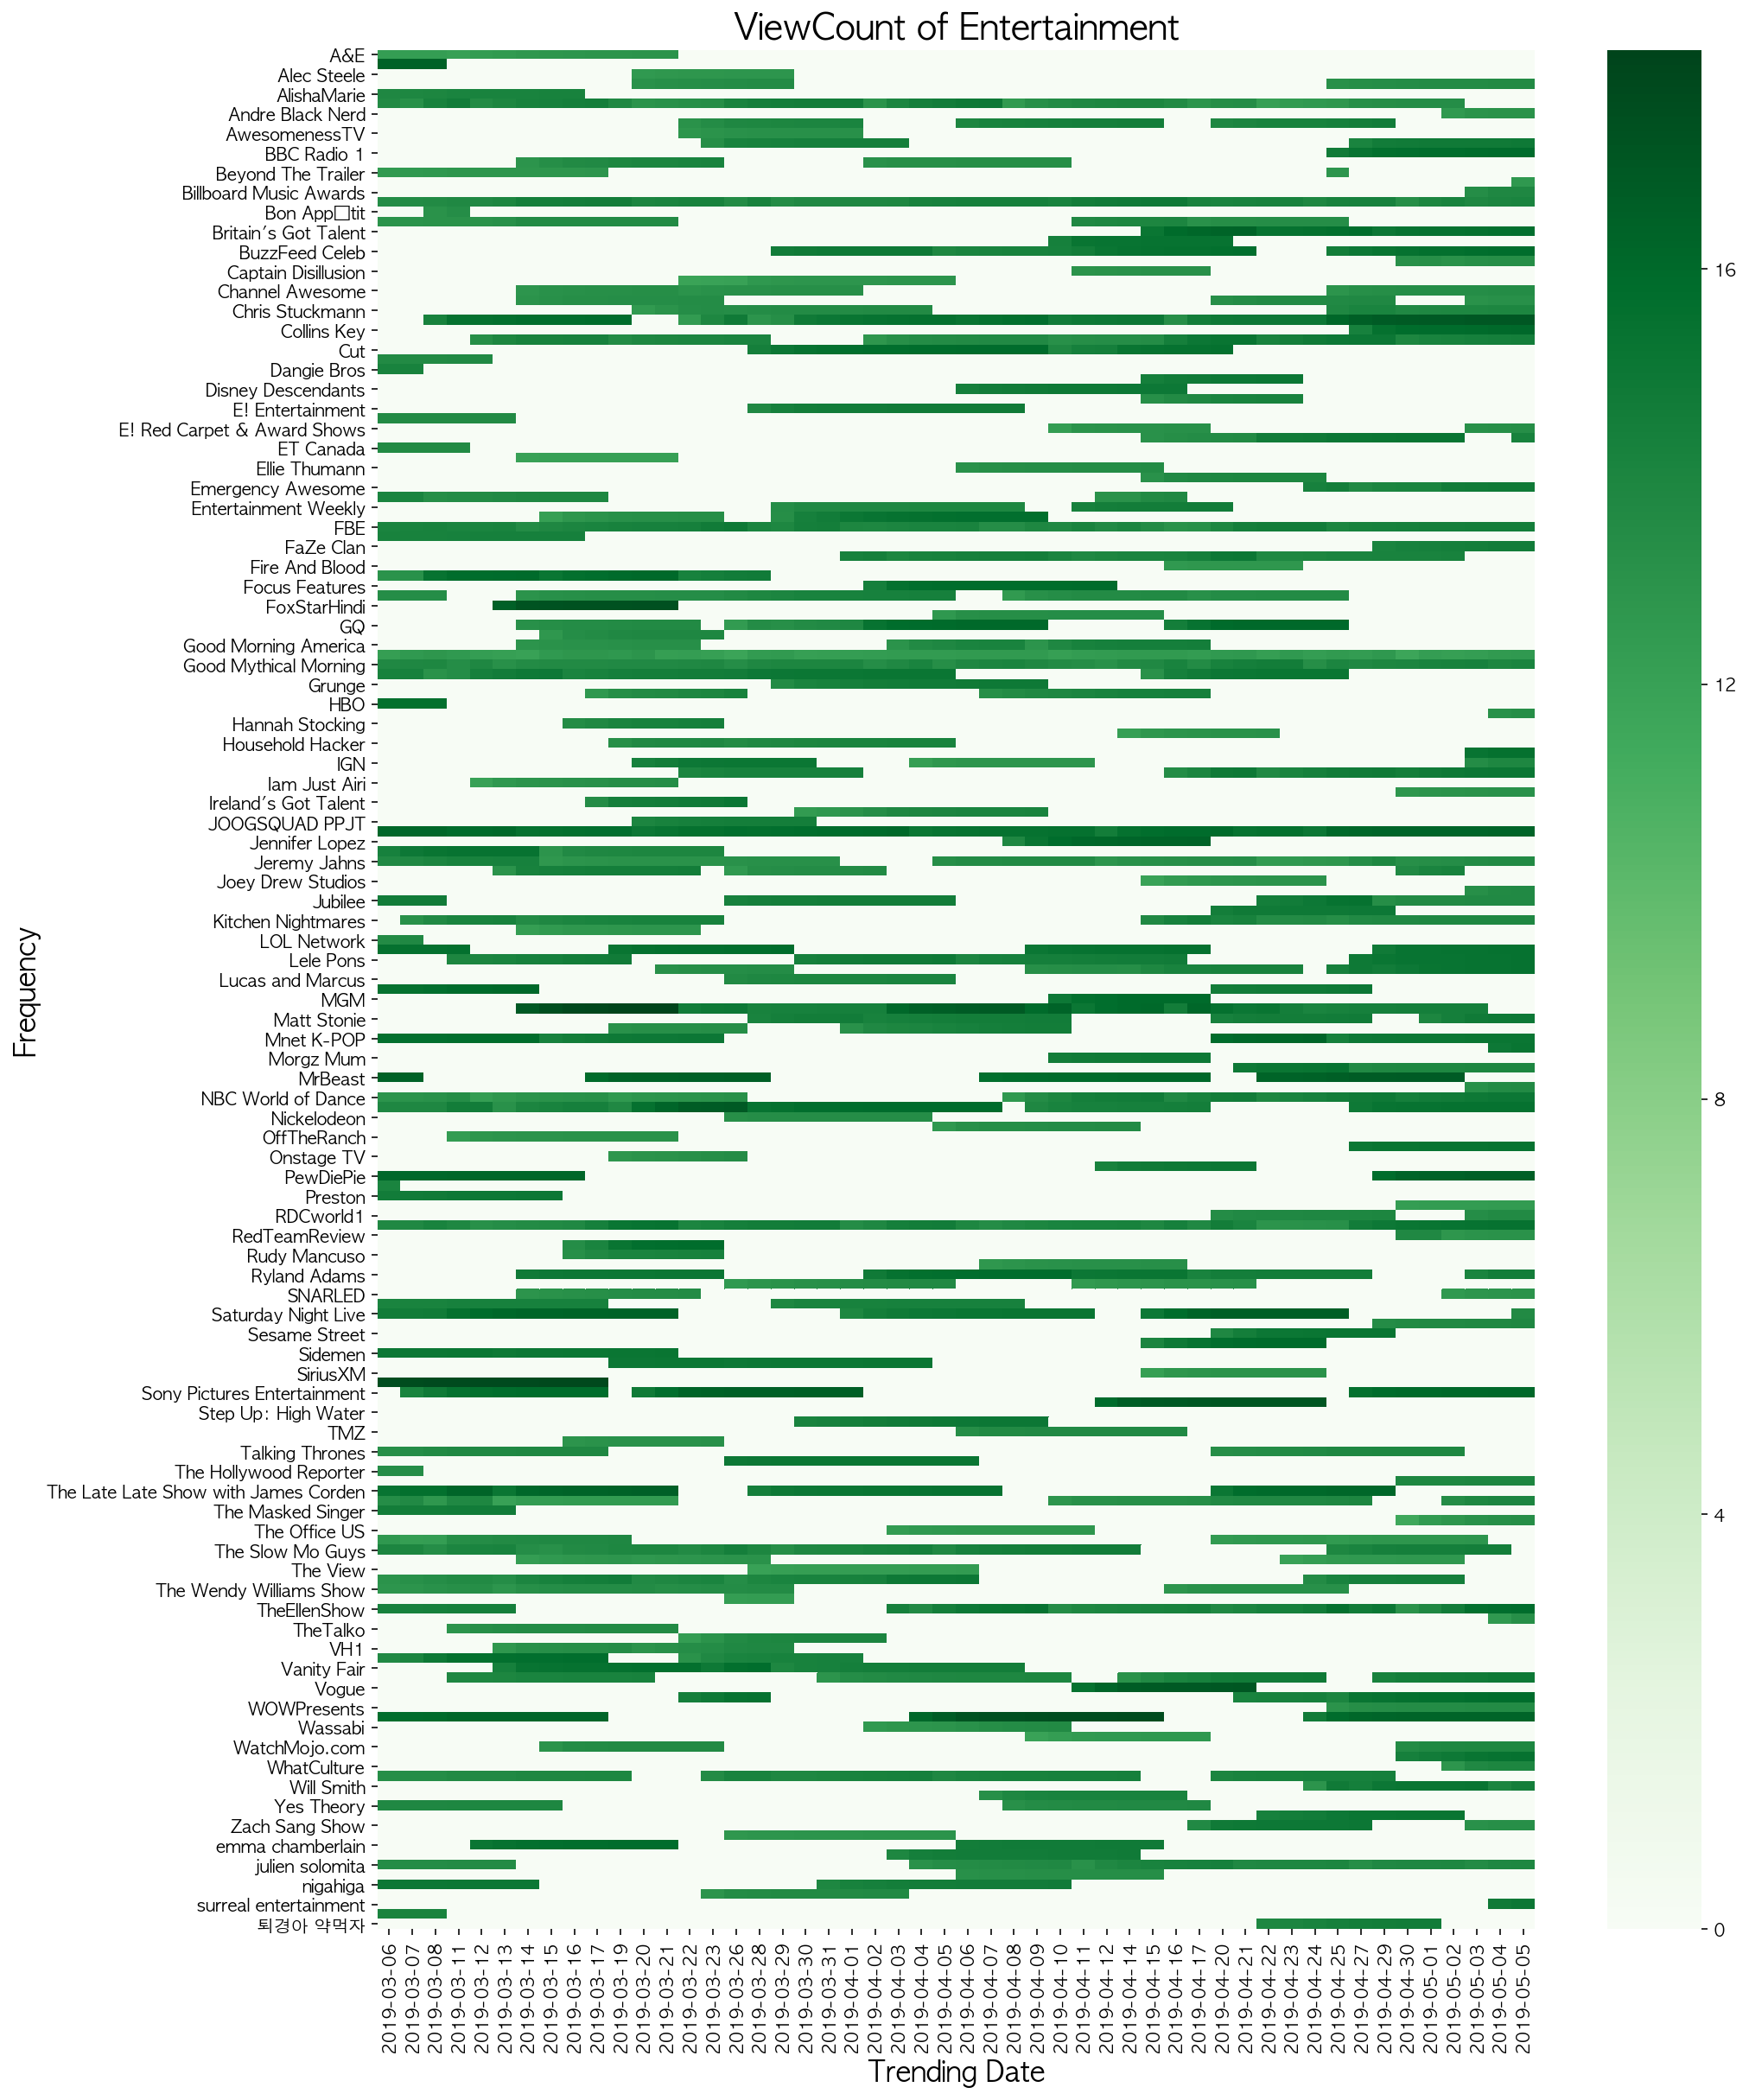

In [15]:
# Create Heatmap
def channelHeatmap(category):
    plt.figure(figsize=(15,20))
    pivot_table = data[data.category == category].pivot_table(index='channelTitle',
                                                             columns='trending_date',
                                                             values='view_count',
                                                             aggfunc=lambda x:np.log(x.mean()+1),
                                                              fill_value=0)
    sns.heatmap(pivot_table, cmap='Greens', vmin=0)
    plt.title('ViewCount of {}'.format(category), fontsize=20)
    plt.xlabel('Trending Date', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show();

channelHeatmap("Entertainment")
                                                            


### Like to Dislike Ratio

`Likes_to_dislikes ratio` = `number of likes` / `dislikes`  

which could easily target the channels which have more potential to get audience pleasure.

In [16]:
# Entertainment
Entertainment['likes_to_dislikes'] = Entertainment['likes']/Entertainment['dislikes']
Matrix2['likes_to_dislikes']= pd.DataFrame(Entertainment['likes_to_dislikes'].groupby(Entertainment['channelTitle']).mean())

/Users/jahoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


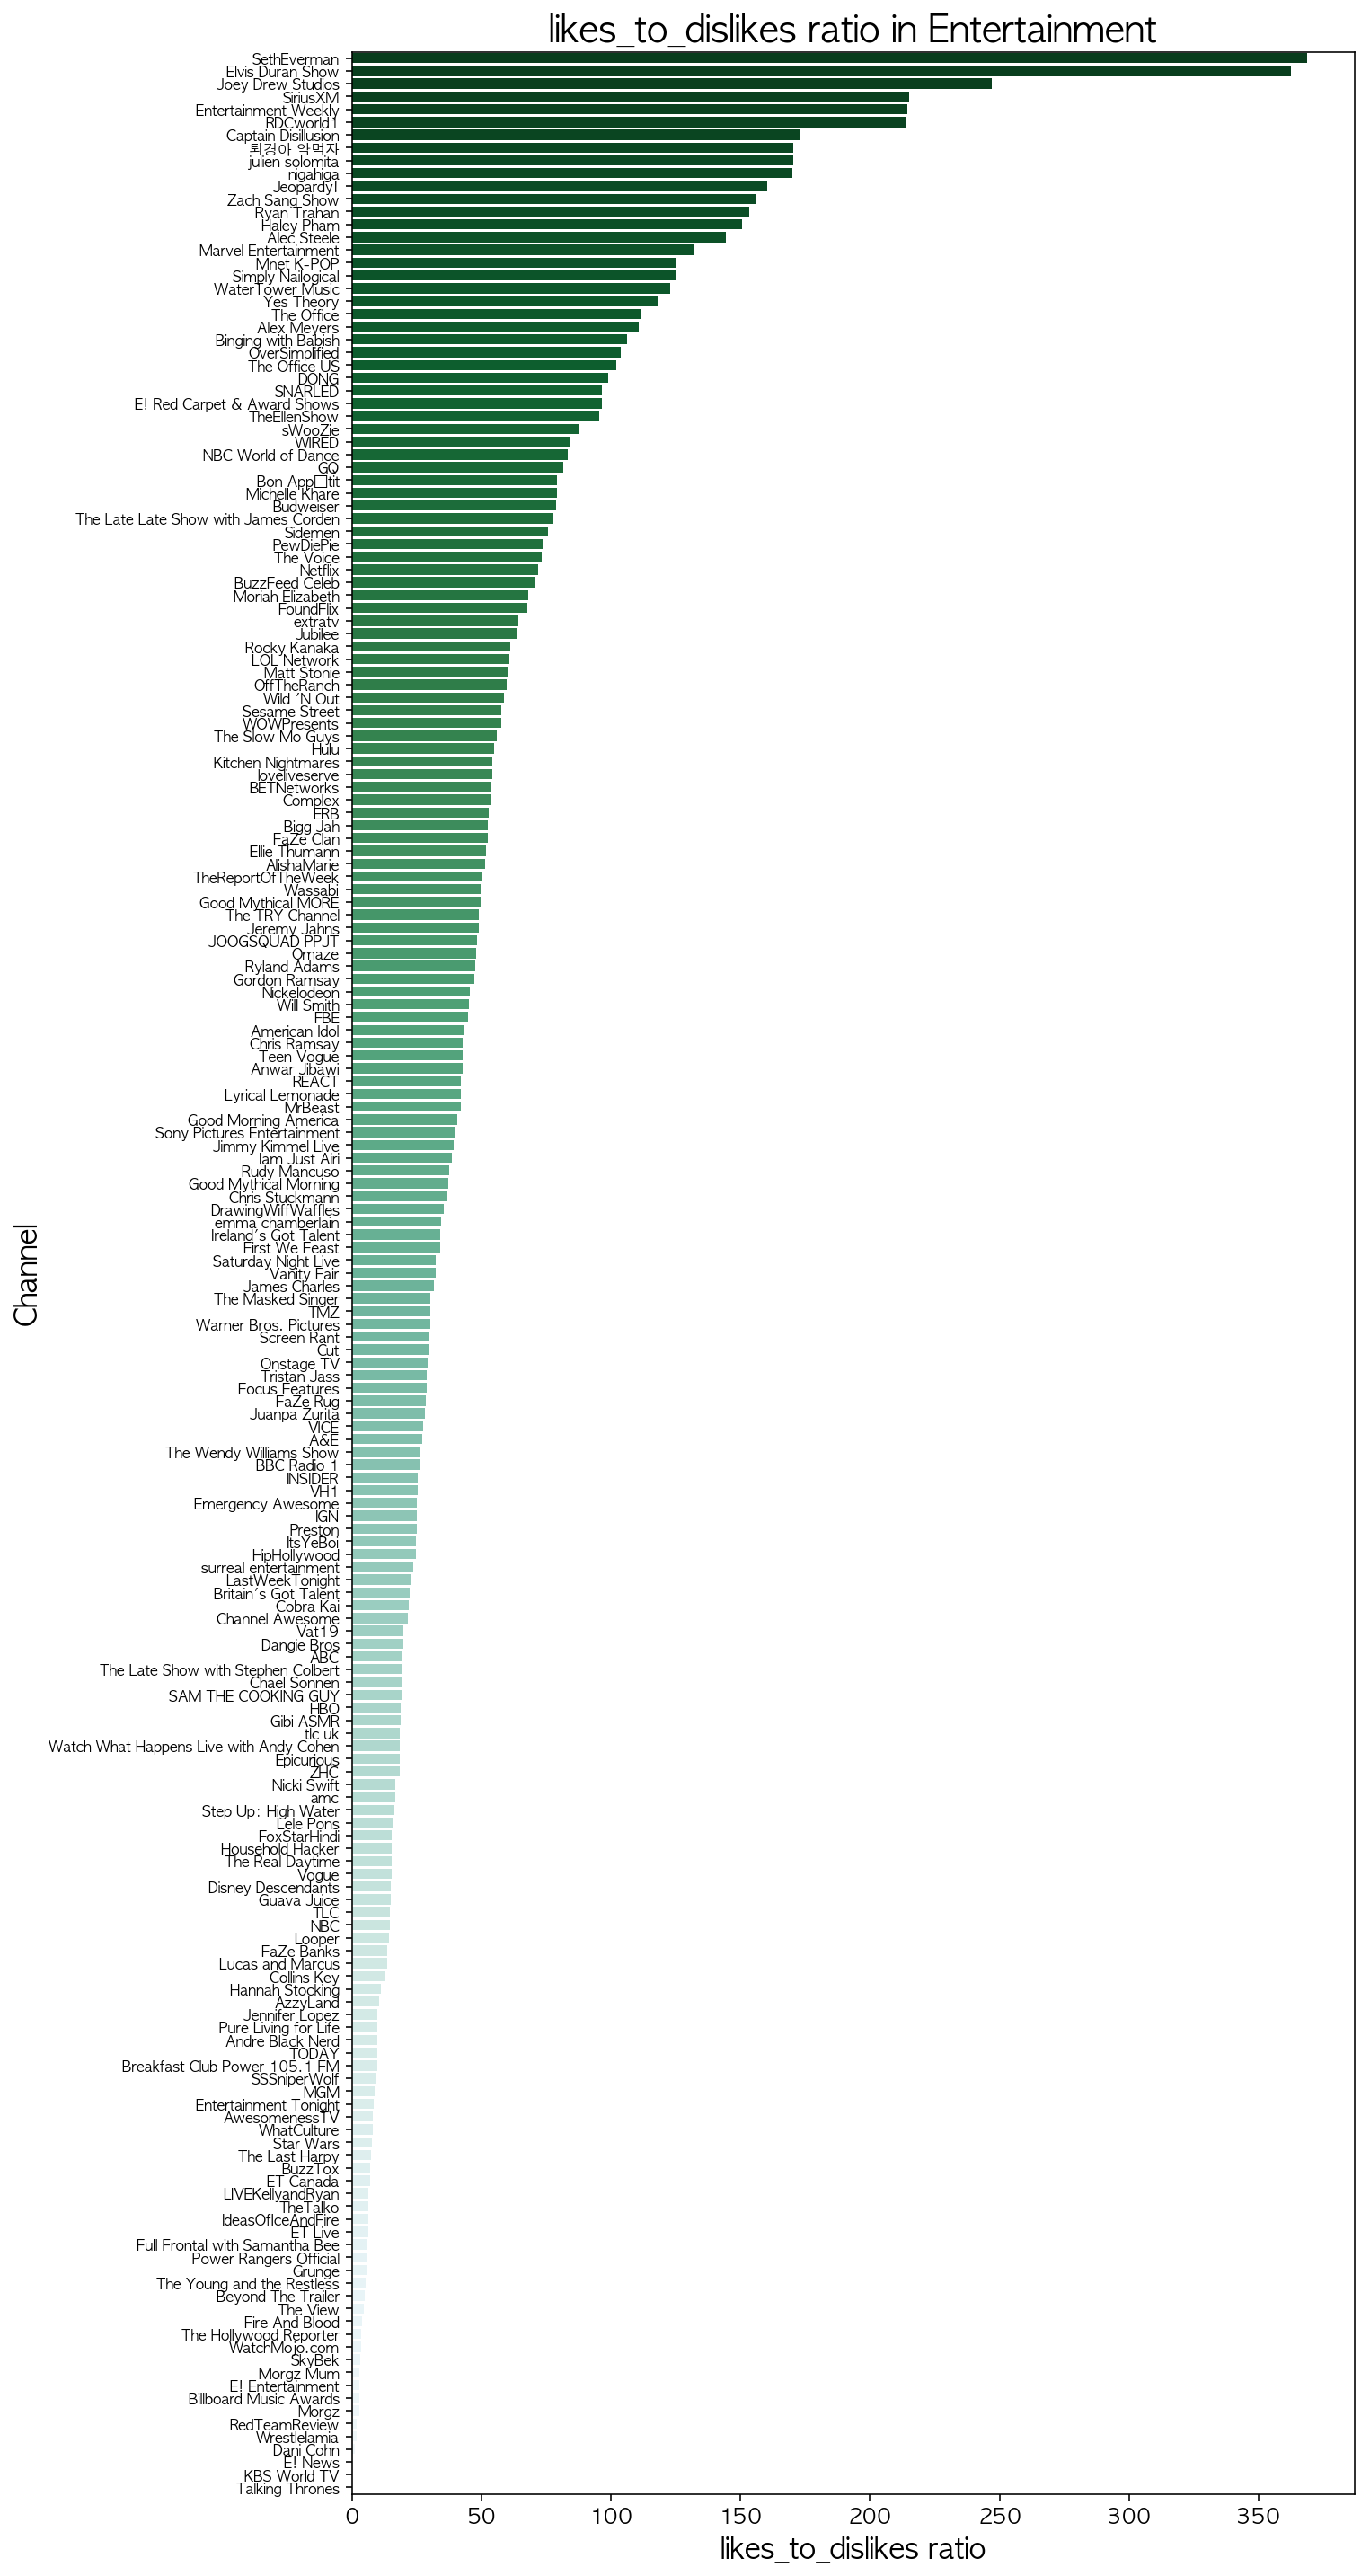

In [17]:
# Plot for Entertainment
plt.figure(figsize = (10,25))
sns.barplot(x=Matrix2['likes_to_dislikes'], y=Matrix2.index, palette=sns.color_palette("BuGn_r",200),order=Matrix2['likes_to_dislikes'].sort_values(ascending=False).index)
plt.xlabel('likes_to_dislikes ratio',fontsize=16)
plt.ylabel('Channel',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8) 
plt.title('likes_to_dislikes ratio in Entertainment',fontsize=20)
plt.show();


The top channels appear here are SethEverman, Elvis Duran Show, Joey Drew Studios, etc, which have more potential to get audience pleasure.

## Growth Rate

`growth rate` = `total number of view_count` / `(trending date - publishing date)`

which means how many views a channel get daily.

/Users/jahoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


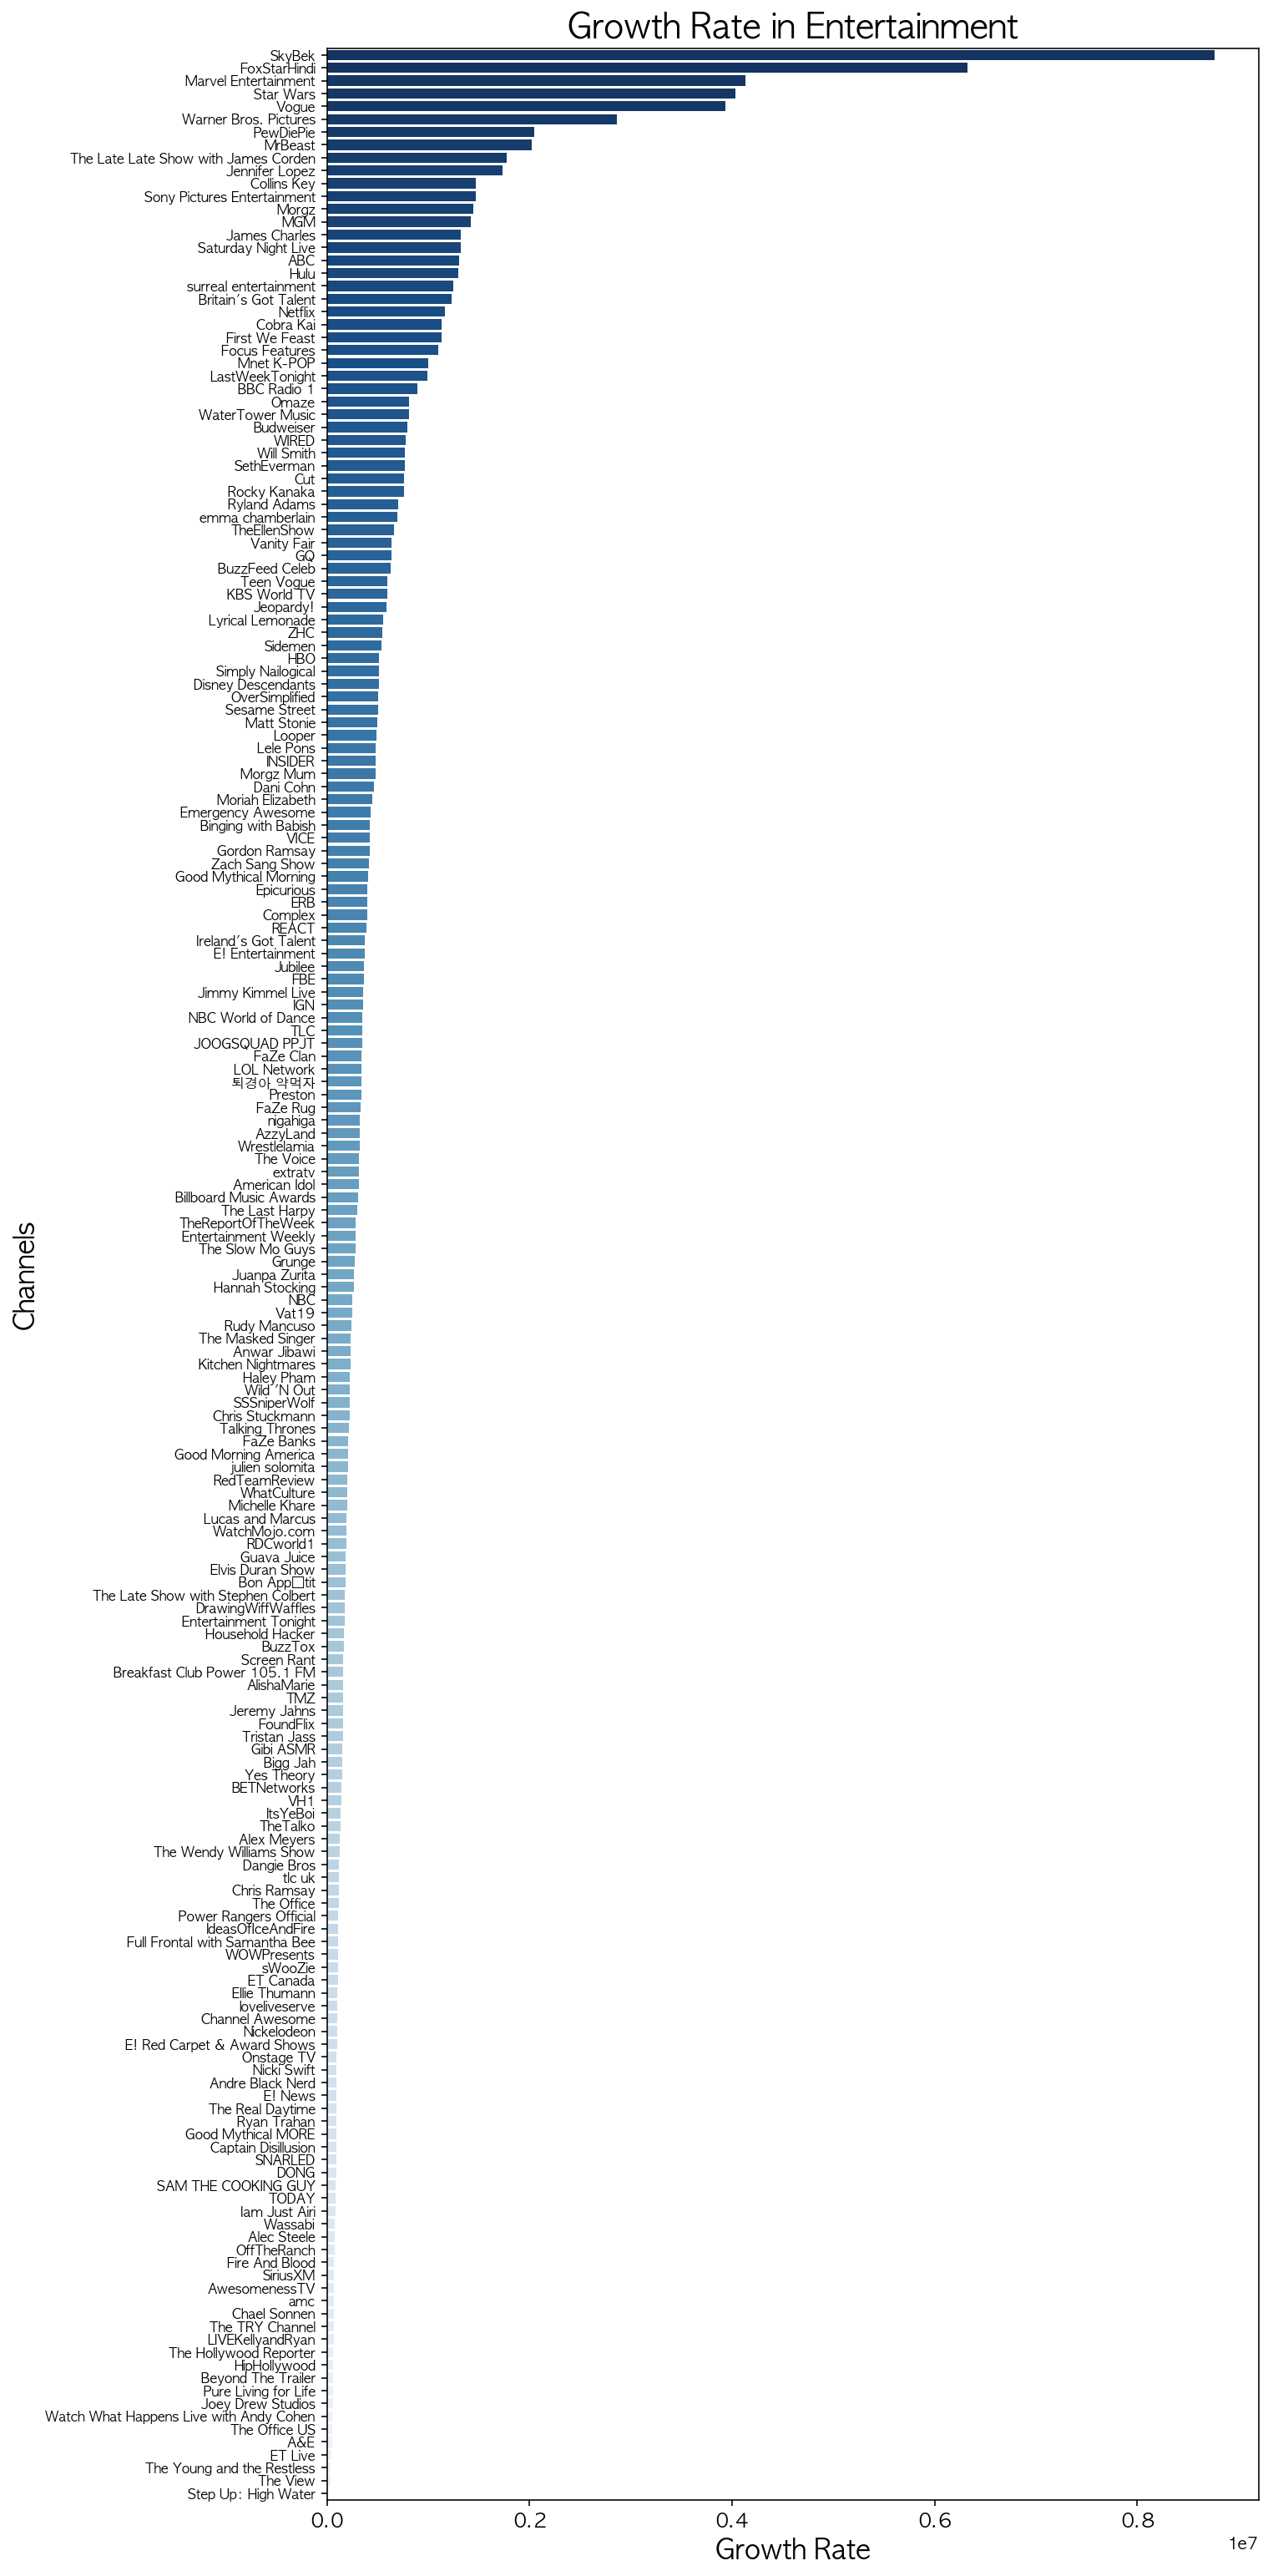

In [18]:
Entertainment['growth_rate']=Entertainment['view_count']/(Entertainment['interval']+1)
Matrix2['growth_rate']=pd.DataFrame(Entertainment['growth_rate'].groupby(Entertainment['channelTitle']).mean())
plt.figure(figsize=(10,27))
sns.barplot(x=Matrix2['growth_rate'],y=Matrix2.index,order=Matrix2['growth_rate'].sort_values(ascending=False).index, palette=sns.color_palette("Blues_r",200))
plt.xticks(fontsize=12)
plt.yticks(fontsize=8) 
plt.xlabel('Growth Rate',fontsize=16)
plt.ylabel('Channels',fontsize=16)
plt.title("Growth Rate in Entertainment", fontsize=20);


The top channels appear here are *SkyBek, FoxSarhindi, Marvel Entertainment*, etc. We may claim these are the topics of public attention trending in these two month because they got more views per day comparing to other channels.

### Sentiment Polarity

I intend to obtain a quick overall sense for what elements a channel performed to audience, So we could recommend a detailed trending YouTube Video image description to help marketing team to identify those potential trending channels.

By using sentiment analyzer from NLTK, I can examine the tags' polarities of each channel in specifical category. Polarity in sentiment analysis refers to identifying sentiment orientation,positive,neutral,and negative.


In [19]:
# Sentiment Analysis
channel_list = Entertainment['channelTitle'].unique()
# Collect all the related stopwords
en_stopwords = list(stopwords.words('english'))
polarities = list()
MAX_N=10000

for i in channel_list:
    tags_word = Entertainment.loc[Entertainment['channelTitle'] == i, 'description']\
                                                        .str.lower().str.cat(sep=' ')
    # Removes punctuation,numbers and returns list of words
    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]
    
    # Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]
    
    # Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N), columns=['Word', 'Frequency'])
    
    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    polarities.append(compound)    
    
    
    
    
    

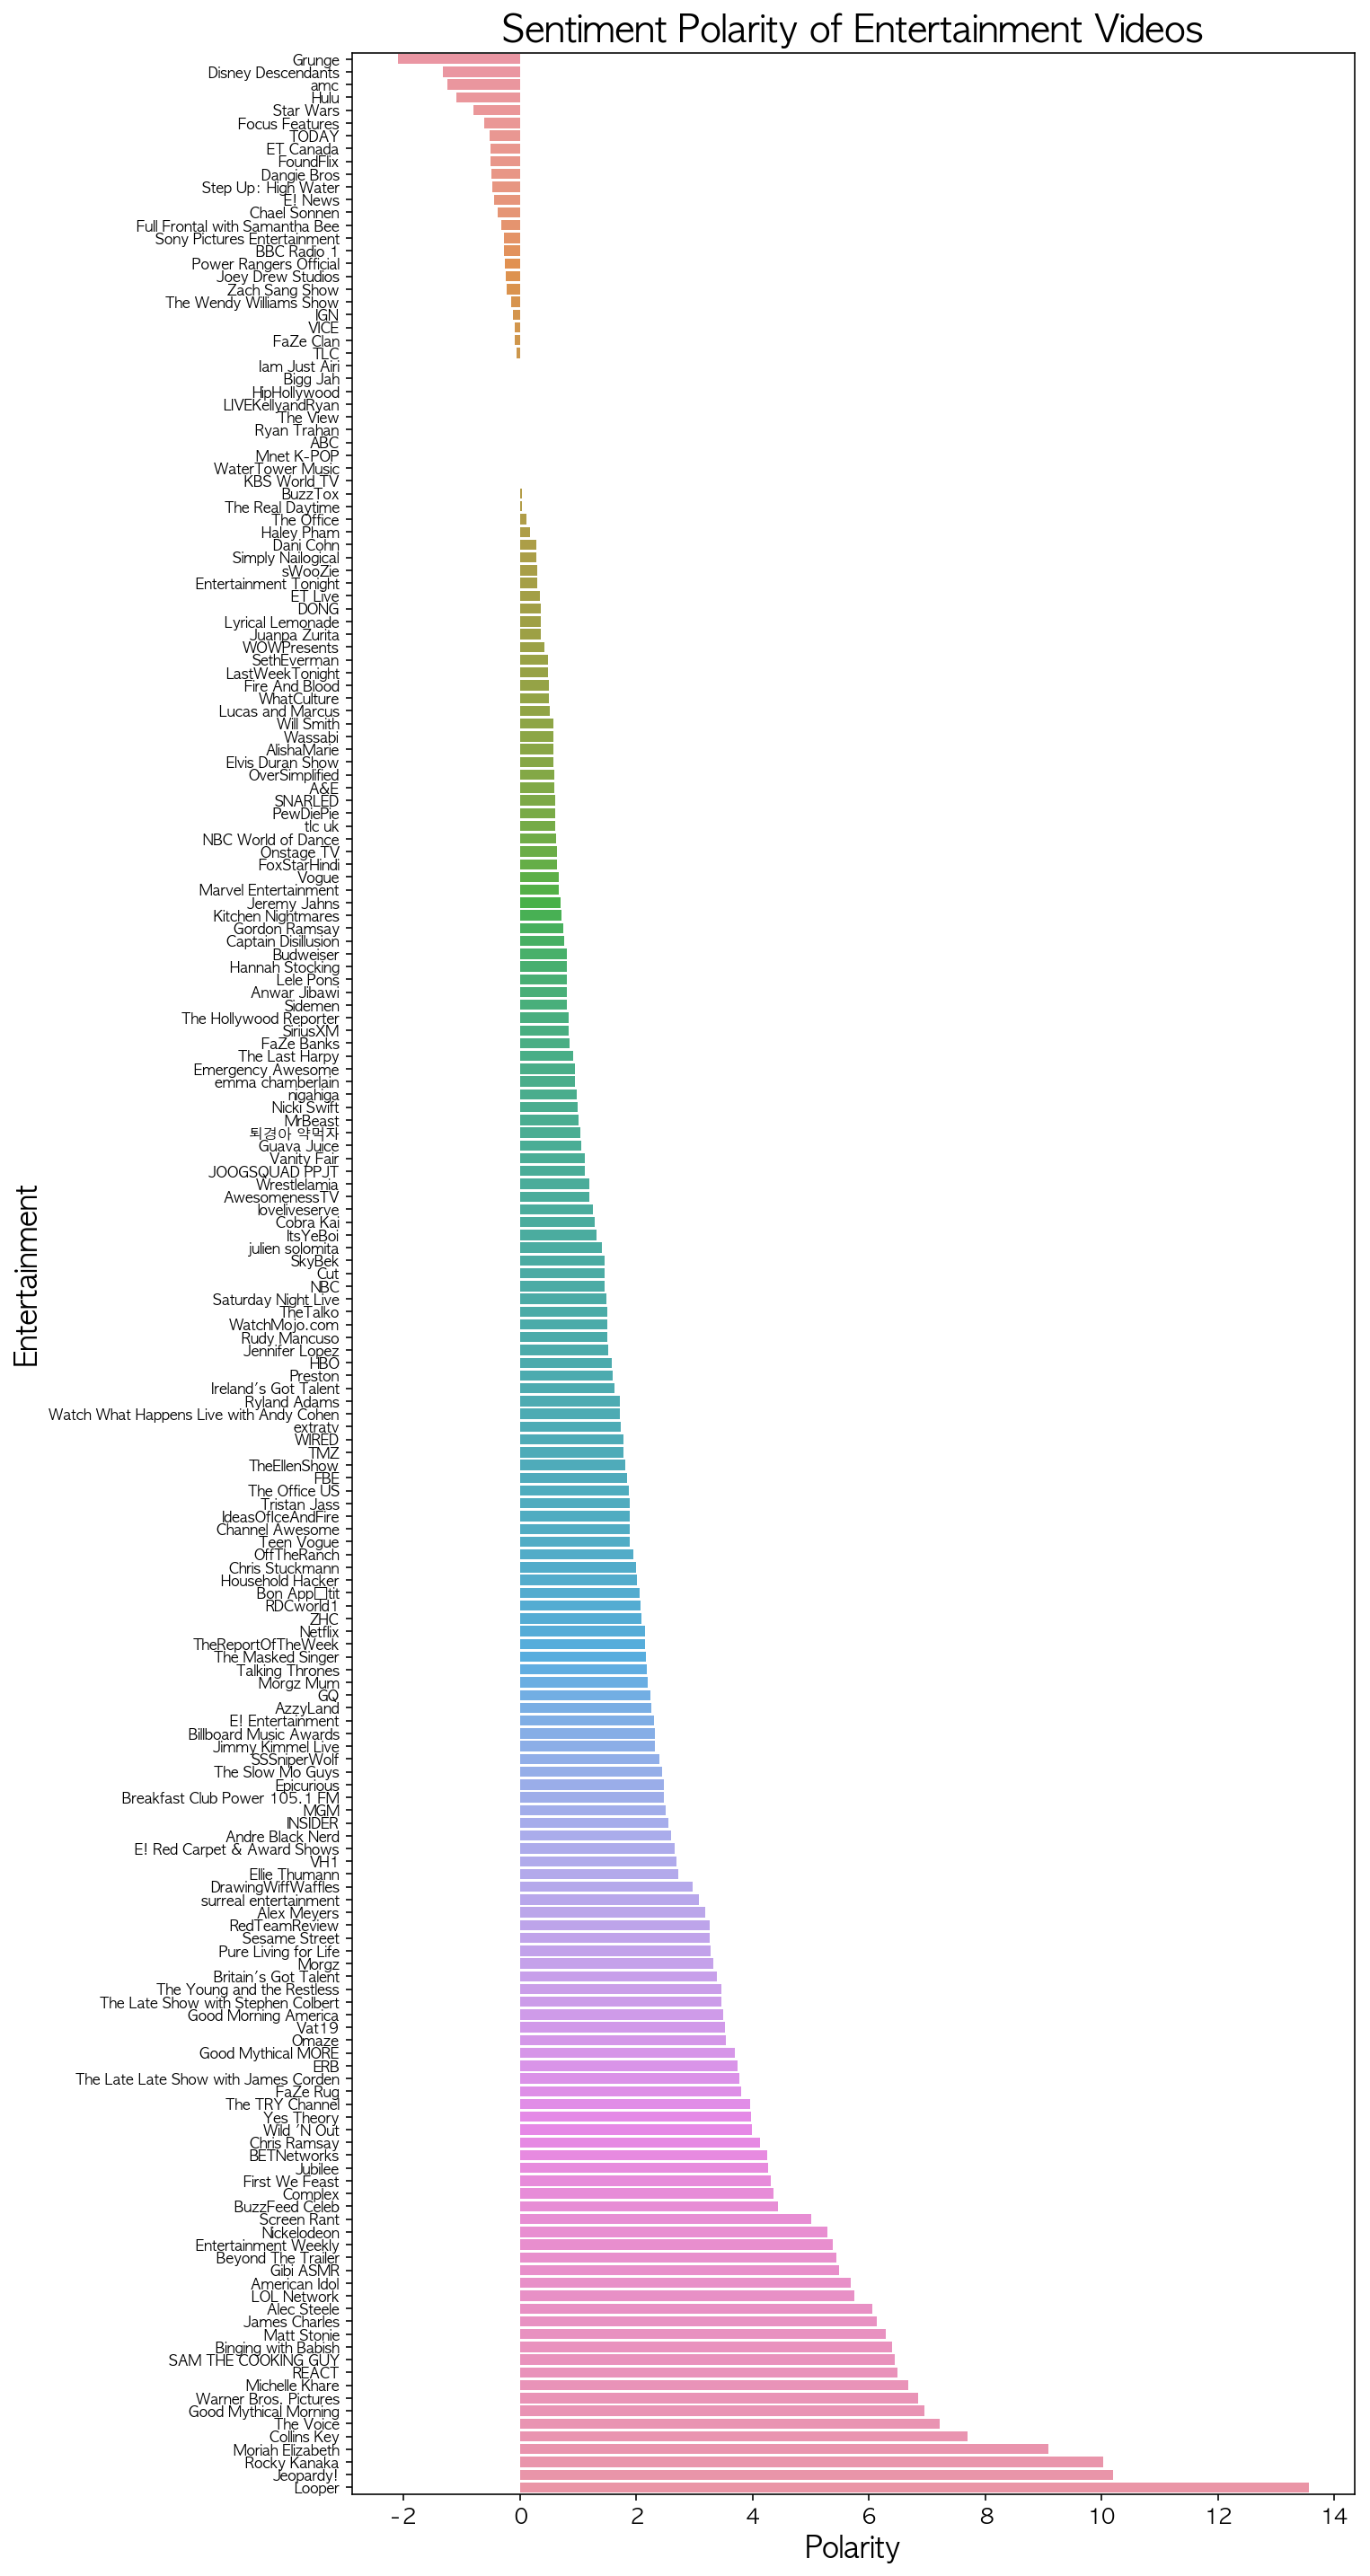

In [20]:
# Plot of Sentiment

channel_list = pd.DataFrame(channel_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([channel_list,polarities], axis=1)

tags_sentiment.columns = ['channelTitle', 'polarity']
tags_sentiment.set_index('channelTitle', inplace=True)
tags_sentiment=tags_sentiment.sort_values('polarity')

plt.figure(figsize=(10,25))
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment.index, data=tags_sentiment)
plt.xlabel("Polarity",fontsize=16)
plt.ylabel("Entertainment",fontsize=16)
plt.yticks(fontsize=8) 
plt.xticks(fontsize=12)
plt.title("Sentiment Polarity of Entertainment Videos", fontsize=20);


In the plot, the channel which has a positive polarity to the videos means it may bring more pleasure watching experience for audience. The plot shows changes of polarities from negative to neutral and positive sentiment among Entertainment channels. Accordong to the plot we can see most of the channels are showing positive directions.


### Matrix Evaluation

In the evaluation matrix, including `appearance frequency`, `growth rate`, `likes to dislikes ratio`, and `sentiment polarity`. I will use the reverse rank of each attribute as its score for channels, then sum up all the scores to get a final score of each channel to select most favorable and the hottest channel to do further analysis.

In [21]:
# Matrix for Entainment
Matrix2['Frequency_Rank'] = Matrix2['Appearance_Frequency'].rank(ascending=1)
Matrix2['Growth_Rank']=Matrix2['growth_rate'].rank(ascending=1)
Matrix2['Potential_Rank']=Matrix2['likes_to_dislikes'].rank(ascending=1)
Matrix2=Matrix2.join(tags_sentiment, how='left')
Matrix2['Sentiment_Rank']=Matrix2['polarity'].rank(ascending=1)



Matrix2.drop(['Appearance_Frequency', 'growth_rate','likes_to_dislikes','polarity'],axis=1,inplace=True)
Matrix2['Score']=Matrix2.sum(axis=1)
Matrix2.sort_values('Score',ascending=False,inplace=True)
Matrix2.head(10)


,Frequency_Rank,Growth_Rank,Potential_Rank,Sentiment_Rank,Score
channelTitle,,,,,
Binging with Babish,188.5,131.0,166.0,180.0,665.5
The Late Late Show with James Corden,167.0,183.0,152.0,159.0,661.0
Jeopardy!,120.0,148.0,178.0,190.0,636.0
James Charles,188.5,177.0,92.0,178.0,635.5
BuzzFeed Celeb,162.5,151.0,147.0,169.0,629.5
Netflix,182.0,171.0,148.0,124.0,625.0
Warner Bros. Pictures,165.0,186.0,89.0,184.0,624.0
Matt Stonie,154.5,139.0,140.0,179.0,612.5
The Voice,169.0,105.0,149.0,186.0,609.0


*Binging with Babish, The Late Late Show with James Corden, Jeopardy!, James Charles* etc got higher scores. I can recommend these kind of channel to marketing team. Before recommending these channels, I will analyze the topic of the channel using word cloud to see what is the main topic of this channel, then we could choose the best channel to advertise our business.

### Find the main topic of these channels

In [26]:
# function of plotting spidermap

def spidermap(Channel_Name):
    Channel=Matrix2.loc[Matrix2.index==Channel_Name]
    Spider = pd.DataFrame({
        'group':[Channel_Name],
        'Frequency': Channel['Frequency_Rank'].values,
        'Growth': Channel['Growth_Rank'].values,
        'Potential': Channel['Potential_Rank'].values,
        'Sentiment': Channel['Sentiment_Rank'].values
    })
    
    N=4
    categories=list(Spider)[1:]
    plt.figure(figsize=(8,8))
    values=Spider.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([50,100,150,200], ["50","100","150"], color="grey", size=13)
    plt.ylim(0,200)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(Channel_Name)
    plt.show()
    

In [27]:
# function of creating word cloud

def word_cloud(Channel_Name):
    Channel = data.loc[data['channelTitle']==Channel_Name]
    tags_word = data.loc[data['channelTitle']==Channel_Name, 'description'].to_string().lower()
    word_tokens =word_tokenize(tags_word)
    cloud = WordCloud(background_color = 'black', colormap="tab20b_r",max_words=2000, max_font_size=40, random_state=42)
    cloud.generate(' '.join(word_tokens))
    
    plt.figure(figsize = (10,10),facecolor = None)
    plt.imshow(cloud)
    plt.axis('off')
    plt.title("\nWord cloud for {}\n".format(Channel_Name), fontsize=20)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords] # stopword 제거
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]  #single word 제거
    Channel_Name = [word for word in without_single_chr if not word.isdigit()]  #digit 제거
                         
                         

### Recommendation 1: Binging with Babish
It is the top 1 channel in entertainment category and it can bring audience the most pleasure experience

                     view_count    likes  dislikes  comment_count
channelTitle                                                     
Binging with Babish  1503321.32  54512.8    567.16        3968.86


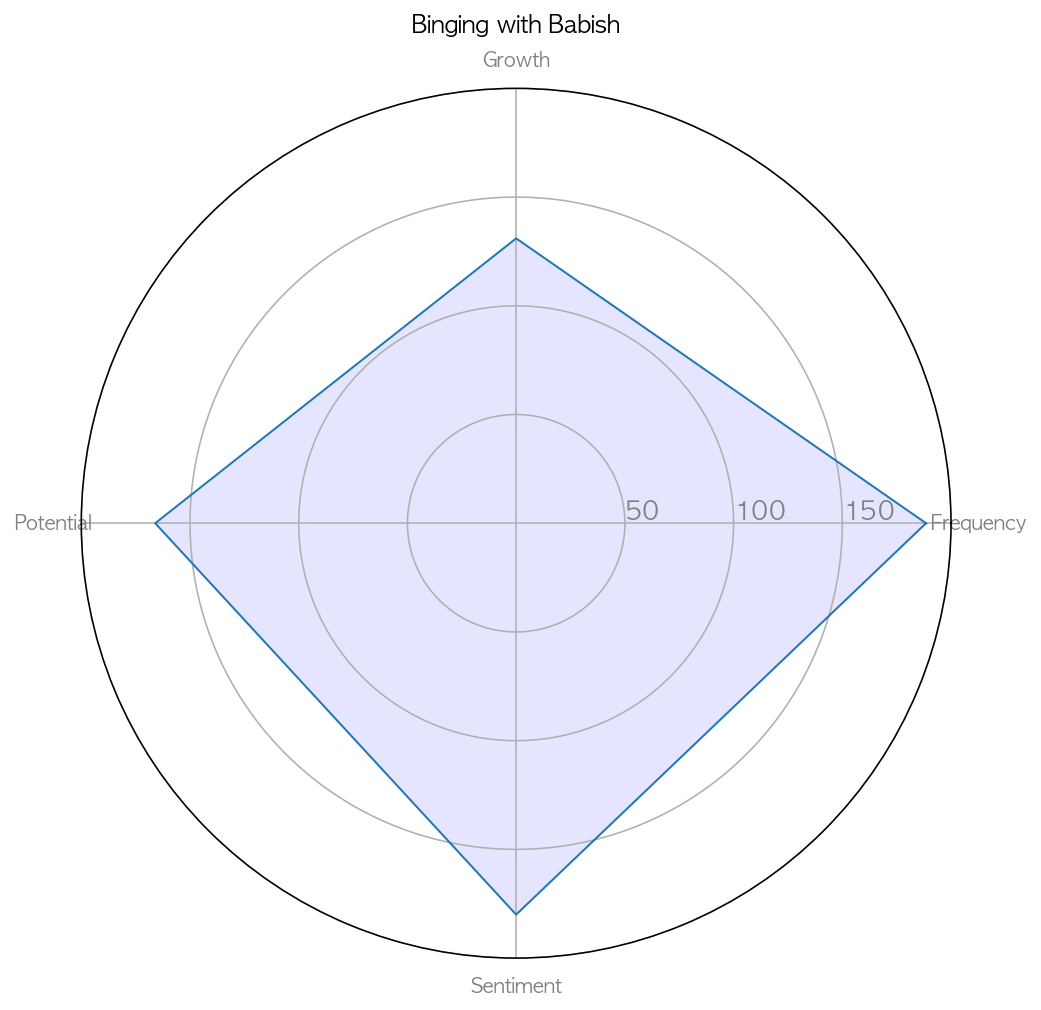

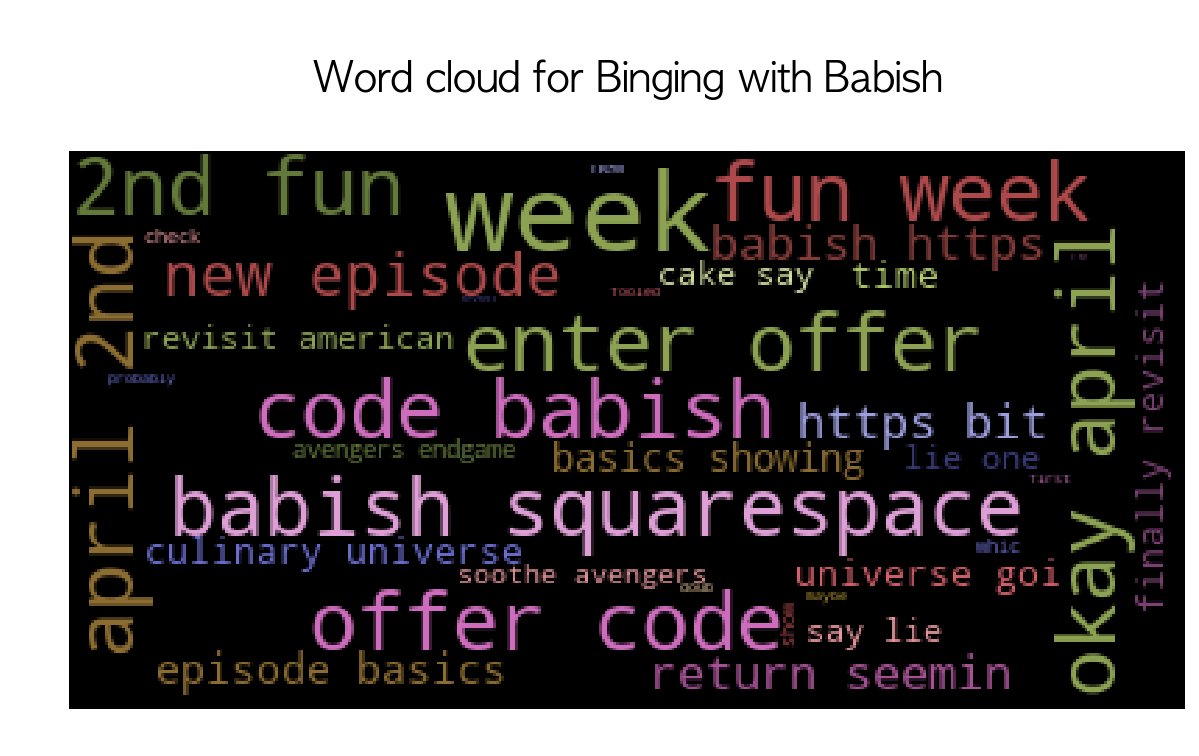

In [28]:
channel_view=pd.DataFrame(data[['view_count','likes','dislikes','comment_count']].groupby(data['channelTitle']).mean())
print(channel_view.loc[channel_view.index=='Binging with Babish'])
spidermap('Binging with Babish')
word_cloud('Binging with Babish')




From the spider map, "Binging with Babish" Channel reflects excellent performance in all four indicators, growth rate, frequency, sentiment scores, and likes_to dislikes ratios and has over 4 million subscribers. Andrew Rea is the host of "Binging with Babish" which focuses on adapting foods from pop culture, which sounds fluffy but is surprisingly dense with useful cooking information. For instance, demonstrates how to make pasta from scratch, among many other useful techniques. The lists of equipment and shopping are comprehensive and the content and quality of the video the design of video with text attract what the audience's preference. The host of Binging with Babish, Andrew Rea has a strong personal brand and his video mostly goes to all the cooks or even househusbands and housewives that want to be able to make something new receipts. What impressed me most is that the channel focuses on how to make the best efforts on creating delicious dishes with the most precise step descriptions efficiently and effectively.


### Recommendation 2: MrBeast

It is the hottest channel in entertainment category and always recieves people's attention quickly.

                view_count          likes      dislikes  comment_count
channelTitle                                                          
MrBeast       1.289917e+07  477637.448276  11808.034483        63544.0


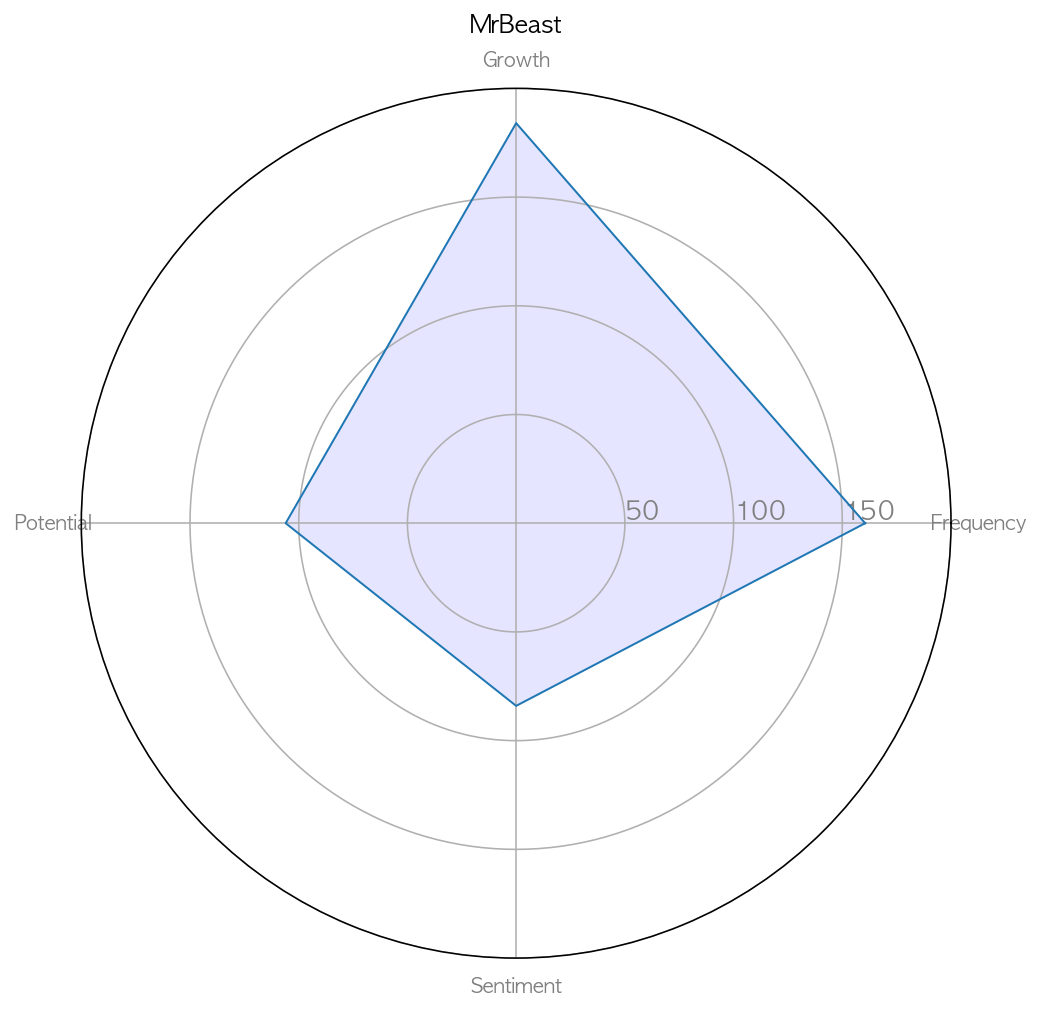

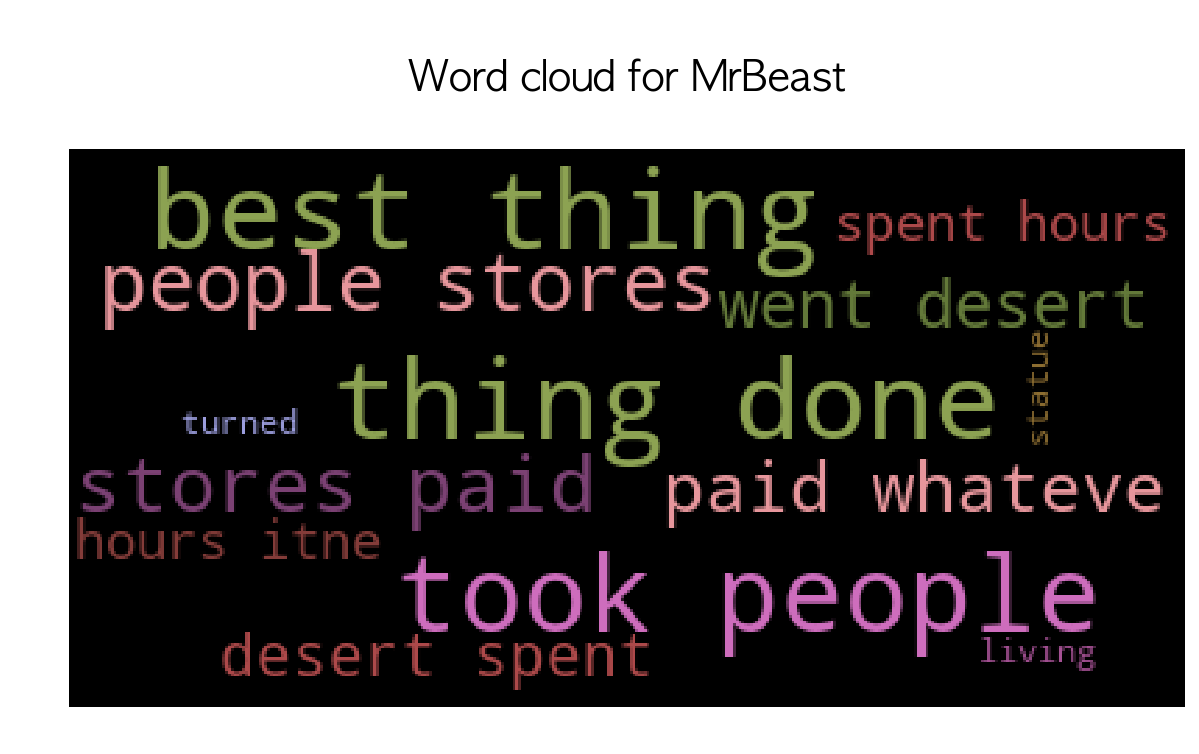

In [31]:
print(channel_view.loc[channel_view.index=='MrBeast'])
spidermap('MrBeast')
word_cloud('MrBeast')

I found MrBeast is a very controversial Channel. After I look up on YouTube, I learned this channel, which has 18 million subscribers already, is focusing on embressing public challenges such as let people siging fake petition, or giving $10000 to random people to see their reaction. It shows very high score of growth rate and high appearance frequency, but very low sentiment and potential. 

## Conclusion

In my report, I develped two major evaluation matrixs to analyze the value of categories and channels on YouTube so as to help marketing team select channels that is worth to advertise or cooperate. Based on the YouTube data I scrapyed from March to May, I found that `entertainment` category is the most valuable category with the best overall performance. So, I digged into entertainment category, and my finding was that **Binging with Babish Channel** is the most favourable and hot channel in entertainment category. As a result, I would like to recommend *Binging with Babish channel* to marketing team, while I also recommend a controversial Channel, **MrBeast**, since it appears to has high attraction on people.